# Model Prediction Analysis

In [ ]:
# Standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ieeg.auth import Session
from itertools import chain
import scipy as sc
from statannot import add_stat_annotation
plt.rcParams['image.cmap'] = 'magma'
from functools import reduce

# ML Imports
from sklearn.metrics import cohen_kappa_score, f1_score, matthews_corrcoef
import statsmodels.formula.api as smf

# OS imports
from os.path import join as ospj
from os.path import exists as ospe
from tqdm import tqdm
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
import os

In [1]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2

plt.rcParams['xtick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['ytick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['xtick.minor.size'] = 3   # Change to your desired minor tick size
plt.rcParams['ytick.minor.size'] = 3   # Change to your desired minor tick size

plt.rcParams['xtick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['ytick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['xtick.minor.width'] = 1  # Change to your desired minor tick width
plt.rcParams['ytick.minor.width'] = 1  # Change to your desired minor tick width
pal = sns.color_palette('Set2')[:2][::-1] + ['grey']

NameError: name 'plt' is not defined

In [ ]:
usr,passpath,datapath,prodatapath,metapath,figpath,patient_table,rid_hup,pt_list = load_config(ospj('/mnt/sauce/littlab/users/wojemann/stim-seizures/code','config.json'))

## Workspace Preparation

In [ ]:
sz_metadata = pd.read_csv(ospj(metapath,'stim_seizure_information_BIDS.csv'))
sz_metadata.head()

,Unnamed: 0,Patient,IEEGname,EEC,UEO,Other_onset_description,approximate_onset,end,source,stim,stim_channels,EEC onset channels,UEO onset channels,Notes,to_annotate,typical,LVFA,Summaries,IEEGID
0,0,HUP224,HUP224_phaseII,71156.5913,71156.58349,NaN,71156.5900,71190.99,Will manual,1.0,LB1-LB2,"LB1,LB2,LB3,LB4,LB5,LC1,LC2,LC3,LC4,LA1,LA2,LA...",NaN,NaN,1.0,0.0,0.0,456.0,0.0
1,1,HUP224,HUP224_phaseII,202170.6825,202170.68250,NaN,202170.6800,202243.03,Erin manual,0.0,NaN,NaN,"RB2,RB3,RC2",NaN,NaN,NaN,NaN,34.0,0.0
2,2,HUP224,HUP224_phaseII,227267.9559,227267.95590,NaN,227267.9600,227350.65,Erin manual,0.0,NaN,NaN,"RB2,RB3,RC2",NaN,NaN,NaN,NaN,56.0,0.0
3,3,HUP224,HUP224_phaseII,339135.7773,339143.64350,NaN,339143.6435,339234.20,Erin manual,0.0,NaN,NaN,"RB2,RB3,RC2",NaN,1.0,NaN,NaN,NaN,0.0
4,4,HUP224,HUP224_phaseII,415736.8300,415751.71870,NaN,415751.7187,415805.57,Erin manual,0.0,NaN,NaN,NaN,no channels,NaN,NaN,NaN,NaN,0.0


In [ ]:
# Loading seizure level metadata
# mdl_str = 'NRG'
# final_thresh = 0.415
# sz_annots = pd.read_pickle(ospj(prodatapath,f"optimized_predicted_channels_{mdl_str}_{final_thresh}.pkl"))
# sz_annots = pd.read_pickle(ospj(prodatapath,f"kdeknee_predicted_channels_opt_allpts.pkl"))
mdl_str = 'LSTM'
sz_annots = pd.read_pickle(ospj(prodatapath,f"optimized_predicted_channels_{mdl_str}_tuned_thresholds_v3.pkl"))
# sz_annots = sz_annots[sz_annots.Patient != 'HUP275']
sz_annots.columns = [col if col != 'Patient' else 'patient' for col in sz_annots.columns]
# sz_annots = sz_annots[sz_annots.Patient.apply(lambda x: x[:3] != 'CHO')]
sz_annots[sz_annots.patient == 'HUP257'].head(10)

,patient,iEEG_ID,model,stim,approximate_onset,offset,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,sec_chs_loose,sz_chs,sz_times,all_channels
344,HUP257,HUP257_CCEP,LSTM,1.0,8576.7900,8644.13,2.168224,"[RA01, RA02, RA03, RA04, RA05, RA06, RB04, RB0...","[RA01, RA02, RA03, RA04, RA05, RA06, RA07, RB0...","[RA01, RA02, RA03, RA04, RA05, RA06, RB04, RB0...","[RA01, RA02, RA03, RA04, RA05, RA06, RA07, RB0...","[RA01, RA02, RA03, RA04, RA05, RA06, RA07, RB0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0,...","[RA01, RA02, RA03, RA04, RA05, RA06, RA07, RA0..."
345,HUP257,HUP257_phaseII,LSTM,0.0,387682.6246,387905.13,2.766355,"[RA02, RA03, RB01, RB02, RC02, RC03]","[RA02, RA03, RA04, RB01, RB02, RB03, RC02, RC0...","[RA01, RA02, RA03, RB01, RB02, RC01, RC02, RC03]","[RA01, RA02, RA03, RA04, RB01, RB02, RB03, RC0...","[RA01, RA02, RA03, RA04, RA05, RA06, RA07, RA0...","[5.5, 0.0, 0.0, 20.5, 58.5, 56.5, 69.5, 65.0, ...","[RA01, RA02, RA03, RA04, RA05, RA06, RA07, RA0..."
346,HUP257,HUP257_phaseII,LSTM,0.0,402021.7200,402136.19,2.766355,"[RA02, RA03, RB01, RB02, RB03, RB04, RC02, RC03]","[RA02, RA03, RA04, RB01, RB02, RB03, RB04, RB0...","[RA01, RA02, RA03, RA04, RB01, RB02, RB03, RC0...","[RA01, RA02, RA03, RA04, RA05, RB01, RB02, RB0...","[RA01, RA02, RA03, RA04, RA05, RA06, RB01, RB0...","[2.0, 0.0, 0.0, 1.0, 16.5, 40.5, 0.0, 0.0, 0.0...","[RA01, RA02, RA03, RA04, RA05, RA06, RA07, RA0..."
347,HUP257,HUP257_phaseII,LSTM,0.0,412047.4990,412177.16,2.766355,"[RA02, RA03, RA04, RB01, RB02, RB03, RB04, RC0...","[RA02, RA03, RA04, RA05, RB01, RB02, RB03, RB0...","[RA01, RA02, RA03, RA04, RB01, RB02, RB03, RC0...","[RA01, RA02, RA03, RA04, RA05, RB01, RB02, RB0...","[RA01, RA02, RA03, RA04, RA05, RA06, RA07, RA0...","[0.5, 0.0, 0.0, 0.0, 11.5, 40.5, 80.0, 72.0, 9...","[RA01, RA02, RA03, RA04, RA05, RA06, RA07, RA0..."
348,HUP257,HUP257_phaseII,LSTM,0.0,430440.4579,430551.42,2.766355,"[RA02, RA03, RA04, RB01, RB02, RB03, RB04, RC0...","[RA02, RA03, RA04, RA05, RB01, RB02, RB03, RB0...","[RA01, RA02, RA03, RA04, RB01, RB02, RB03, RC0...","[RA01, RA02, RA03, RA04, RA05, RB01, RB02, RB0...","[RA01, RA02, RA03, RA04, RA05, RA06, RB01, RB0...","[1.0, 0.0, 0.0, 0.0, 11.0, 37.0, 0.0, 0.0, 0.0...","[RA01, RA02, RA03, RA04, RA05, RA06, RA07, RA0..."
349,HUP257,HUP257_phaseII,LSTM,0.0,443900.6435,444000.86,2.766355,"[RA01, RA02, RA03, RA04, RA05, RB01, RB02, RB0...","[RA01, RA02, RA03, RA04, RA05, RA06, RB01, RB0...","[RA01, RA02, RA03, RA04, RB01, RB02, RB03, RB0...","[RA01, RA02, RA03, RA04, RA05, RB01, RB02, RB0...","[RA01, RA02, RA03, RA04, RA05, RA06, RA07, RB0...","[0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 42.0, 0.0, 0.0...","[RA01, RA02, RA03, RA04, RA05, RA06, RA07, RA0..."


In [ ]:
print(sz_annots.patient.unique())
print(len(sz_annots[sz_annots.patient.apply(lambda x: 'HUP' in x)]))
print(len(sz_annots[sz_annots.patient.apply(lambda x: 'CHOP' in x)]))
sz_annots[sz_annots.patient == 'HUP257'].ueo_chs_loose.iloc[4]

['CHOP005' 'CHOP024' 'CHOP026' 'CHOP028' 'CHOP035' 'CHOP037' 'CHOP041'
 'CHOP044' 'CHOP045' 'CHOP049' 'HUP224' 'HUP225' 'HUP229' 'HUP230'
 'HUP235' 'HUP238' 'HUP246' 'HUP247' 'HUP249' 'HUP250' 'HUP253' 'HUP257'
 'HUP261' 'HUP263' 'HUP266' 'HUP267' 'HUP273' 'HUP275' 'HUP288']
334
97


array(['RA02', 'RA03', 'RA04', 'RA05', 'RB01', 'RB02', 'RB03', 'RB04',
       'RB05', 'RC01', 'RC02', 'RC03', 'RC04'], dtype='<U4')

In [ ]:
shared_channels = sz_annots.groupby('patient')['all_channels'].transform(lambda x: [list(set.intersection(*map(set, x)))] * len(x))
sz_annots['all_channels'] = shared_channels
sz_annots.sort_values('approximate_onset',inplace=True)

In [ ]:
seizures_df = pd.read_csv(ospj(metapath,"stim_seizure_information - LF_seizure_annotation.csv"))
seizures_df.dropna(axis=0,how='all',inplace=True)
seizures_df.rename(columns=dict(Patient='patient',IEEGname='iEEG_ID'),inplace=True)
seizures_df['approximate_onset'].fillna(seizures_df['UEO'],inplace=True)
seizures_df['approximate_onset'].fillna(seizures_df['EEC'],inplace=True)
seizures_df['approximate_onset'].fillna(seizures_df['Other_onset_description'],inplace=True)
# drop HF stim induced seizures
seizures_df = seizures_df[seizures_df.stim != 2]
seizures_df.sort_values('approximate_onset',inplace=True)

## Seizure Annotation Preparation

### Merging annotations and seizure metadata

In [ ]:
sz_annots = pd.merge_asof(sz_annots,
            seizures_df[['approximate_onset','patient',"iEEG_ID","typical","stim_channels"]],
            on='approximate_onset',by=['patient','iEEG_ID'],
            tolerance = 240,
            direction='nearest')

sz_annots.sort_values(['patient','iEEG_ID','approximate_onset'],inplace=True)

### Mapping channels to regions and adding stim channels

In [ ]:
STIMFLAG = True # Toggle to include or remove stim channels from stim seizure onset zones
pt_groups = sz_annots.groupby('patient')
for pt,group in pt_groups:
    region_path = get_rpath(prodatapath,pt)
    if ospe(region_path):
        electrode_regions = pd.read_pickle(region_path)
        # electrode_regions = surgical_parcellation(electrode_regions)
    for idx,row in group.iterrows():
        if ospe(region_path):
                    sz_annots.at[idx,'all_rs'] = np.array([r for r in electrode_regions[electrode_regions.name.isin(row['all_channels'])]['label'].unique() if ((r != 'EmptyLabel') and ('white' not in r.lower()))])
                
        if STIMFLAG and row.stim == 1:
            stim_chs = clean_labels(row.stim_channels.split('-'),'')
            row.sz_chs = np.concatenate([row.sz_chs,stim_chs])
            row.sz_times = np.concatenate([row.sz_times,[0,0]])
        
        row.sz_rs = np.array([r for r in electrode_regions[electrode_regions.name.isin(row.sz_chs)]['label'] if ((r != 'EmptyLabel') and ('white' not in r.lower()))])            

        for col in ['ueo_chs_strict', 'ueo_chs_loose', 'sec_chs_strict', 'sec_chs_loose']:
            chs = row[col]

            if STIMFLAG and row.stim == 1:
                chs = np.union1d(stim_chs,chs)

            # Creating channel mask
            sz_annots.at[idx,col+'_mask'] = np.array([ch in chs for ch in row['all_channels']])
            # Creating region labels and mask
            if ospe(region_path):
                # got rid of unique region tag after electrode_locals
                electrode_locals = np.array([r for r in electrode_regions[electrode_regions.name.isin(chs)]['label'] if ((r != 'EmptyLabel') and ('white' not in r.lower()))])
                sz_annots.at[idx,col.replace('chs','rs')+'_mask'] = np.array([l in electrode_locals for l in np.atleast_1d(sz_annots.loc[idx,'all_rs'])])
                sz_annots.at[idx,col.replace('chs','rs')] = electrode_locals
        # sz_annots.at[idx,'all_rs'] = electrode_regions[electrode_regions.name.isin(row['all_channels'])]['label'].unique()

sz_annots.dropna(axis=0,subset='stim',inplace=True)
sz_annots.sort_values(['approximate_onset'],inplace=True)


## Annotator Replication

In [ ]:
sz_annots

,patient,iEEG_ID,model,stim,approximate_onset,offset,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,ueo_rs_strict,ueo_chs_loose_mask,ueo_rs_loose_mask,ueo_rs_loose,sec_chs_strict_mask,sec_rs_strict_mask,sec_rs_strict,sec_chs_loose_mask,sec_rs_loose_mask,sec_rs_loose
0,CHOP026,CHOP026,LSTM,0.0,771.890,797.89,1.606020,[LO03],"[LO03, LO04]","[LM01, LM02, LM03, LM04, LN01, LN02, LN03, LN0...",...,[Left-Hippocampus],"[False, False, False, False, False, False, Fal...","[False, True, False, False, False, False, Fals...","[Left-Hippocampus, Left-Hippocampus]","[False, False, False, False, False, False, Fal...","[True, True, False, False, False, False, False...","[Left-Amygdala, Left-Amygdala, Left-Amygdala, ...","[False, False, False, False, False, False, Fal...","[True, True, False, False, False, False, False...","[Left-Amygdala, Left-Amygdala, Left-Amygdala, ..."
1,HUP229,HUP229_phaseII,LSTM,1.0,1109.400,1176.91,3.588785,"[LA02, LA03, LB01, LB02, LB03, LB04, LC01, LC0...","[LA02, LA03, LA04, LB01, LB02, LB03, LB04, LB0...","[LA01, LA02, LA03, LB01, LB02, LB03, LB04, LC0...",...,"[ left amygdala , left hippocampus , left hi...","[False, False, True, True, False, False, False...","[True, True, False, True, True, False, True, F...","[ left amygdala , left superior temporal , l...","[False, False, False, True, False, True, False...","[True, True, True, True, True, False, True, Fa...","[ left amygdala , left amygdala , left hippo...","[False, False, True, True, False, True, True, ...","[True, True, True, True, True, False, True, Fa...","[ left amygdala , left amygdala , left super..."
2,CHOP035,CHOPCCEP_035,LSTM,1.0,2872.350,2899.06,3.097463,"[LM01, LM02, LM03, LM04, LN01, LN05, LN06, LL0...","[LG01, LG02, LG03, LG04, LG05, LL01, LL02, LL0...","[LM01, LM02, LM03, LN01, LN05, LN06, LL01, LL0...",...,"[ctx-lh-parahippocampal, ctx-lh-insula, ctx-lh...","[False, False, False, False, False, False, Tru...","[True, True, True, False, False, True, True, F...","[ctx-lh-parahippocampal, ctx-lh-insula, ctx-lh...","[False, False, False, False, False, False, Tru...","[True, True, False, False, False, True, True, ...","[ctx-lh-parahippocampal, ctx-lh-insula, Left-A...","[False, False, False, False, False, False, Tru...","[True, True, False, False, False, True, True, ...","[ctx-lh-parahippocampal, ctx-lh-insula, ctx-lh..."
3,CHOP026,CHOPCCEP_026,LSTM,1.0,3608.770,3742.56,2.841121,[],[],[LH05],...,[ctx-lh-parsopercularis],"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",[ctx-lh-parsopercularis],"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",[ctx-lh-parsopercularis],"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",[ctx-lh-parsopercularis]
4,HUP230,HUP230_phaseII,LSTM,1.0,3860.240,3878.40,2.189586,"[LC01, LC02]","[LC01, LC02, LC03]","[LC01, LC02, LM04]",...,"[ left superior temporal , left parahippocamp...","[True, False, False, False, False, False, Fals...","[False, False, True, False, False, False, Fals...","[ left superior temporal , left parahippocamp...","[True, False, False, False, False, False, Fals...","[False, False, True, False, False, False, Fals...","[ left superior temporal , left parahippocamp...","[True, False, False, False, False, False, Fals...","[False, False, True, False, False, False, Fals...","[ left superior temporal , left parahippocamp..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,HUP247,HUP247_phaseII,LSTM,0.0,577555.030,577574.76,1.436582,"[RP01, RP02, RP03, RP04, RV04, RV05, RV07, RW0...","[RP01, RP02, RP03, RP04, RP05, RV04, RV05, RV0...","[RP01, RP02, RP03, RP04, RV04, RV05, RV06, RV0...",...,"[ right precuneus , right precuneus , right ...","[False, True, False, False, False, True, False...","[True, True, False, True, False, False, False]","[ right precuneus , right precuneus , right ...","[False, True

### Seizure -- channel

In [ ]:
def calculate_seizure_similarity(annots,first_annot = 'ueo_consensus', second_annot = 'ueo_consensus',paired=True):
    annot_list = ["kappa","F1","MCC","patient","spont","typical"]
    annot_dict = {key:[] for key in annot_list}
    skip_pt = []
    for pt,group in annots.groupby("patient"):
        if (sum(group.stim == 0) < 2) and paired:
            skip_pt.append(pt)
            continue
        elif len(group) < 2:
            skip_pt.append(pt)
            continue
        # Iterate through each seizure
        for i in range(len(group)):
            group.reset_index(drop=True,inplace=True)
            ch_mask = group.loc[i,first_annot].reshape(-1)
            for j in range(i+1,len(group)):
                if (group.loc[i,'stim'] == 1)  and (group.loc[j,'stim'] == 1): # skip both stim
                    continue
                ch_mask2 = group.loc[j,second_annot].reshape(-1)
                annot_dict["kappa"].append(cohen_kappa_score(ch_mask,ch_mask2))
                annot_dict["F1"].append(f1_score(ch_mask,ch_mask2))
                annot_dict["MCC"].append(matthews_corrcoef(ch_mask,ch_mask2))
                annot_dict["spont"].append(not ((group.loc[i,'stim'] == 1)  or (group.loc[j,'stim'] == 1)))
                # want to append a boolean that will tell me if one sz is stim and one sz is typical
                annot_dict["typical"].append(((group.loc[i,'typical'] == 1)  
                                                        or (group.loc[j,'typical'] == 1)))
                annot_dict["patient"].append(pt)
    annot_df = pd.DataFrame(annot_dict)
    print(f"Skipped {skip_pt} due to insufficient spontaneous seizures")
    return annot_df

def calculate_spread_similarity(annots,first_annot = 'sz_chs', second_annot = 'sz_chs', sources = 'all_channels', spread_thresh = 30, paired=True):
    annot_list = ["MCC","Rank","patient","spont","typical"]
    annot_dict = {key:[] for key in annot_list}
    skip_pt = []
    for pt,group in annots.groupby("patient"):
        if (sum(group.stim == 0) < 2) and paired:
            skip_pt.append(pt)
            continue
        elif len(group) < 2:
            skip_pt.append(pt)
            continue
        # Iterate through each seizure
        for i in range(len(group)):
            group.reset_index(drop=True,inplace=True)
            # for each channel in sz_chs, is the time in sz_times less than spread_thresh, and if so set that channel to true
            ch_time_mask = [t < spread_thresh for t in group.loc[i,'sz_times']]
            if len(ch_time_mask) == 0:
                continue
            ch_mask = np.isin(group.loc[i,sources],group.loc[i,first_annot][ch_time_mask])

            onset_dict = dict(zip(group.loc[i,first_annot],group.loc[i,'sz_times']))
            max_latency = group.loc[i,'sz_times'].max() + 1
            all_latencies = np.array([onset_dict.get(ch,max_latency) for ch in group.loc[i,sources]])

            for j in range(i+1,len(group)):
                if (group.loc[i,'stim'] == 1)  and (group.loc[j,'stim'] == 1): # skip both stim
                    continue
                ch_time_mask2 = [t < spread_thresh for t in group.loc[j,'sz_times']]
                if len(ch_time_mask2) == 0:
                    continue
                ch_mask2 = np.isin(group.loc[j,sources],group.loc[j,first_annot][ch_time_mask2])
                onset_dict2 = dict(zip(group.loc[j,first_annot],group.loc[j,'sz_times']))
                max_latency2 = group.loc[j,'sz_times'].max() + 1
                all_latencies2 = np.array([onset_dict2.get(ch,max_latency2) for ch in group.loc[j,sources]])

                annot_dict["MCC"].append(matthews_corrcoef(ch_mask,ch_mask2))
                annot_dict["Rank"].append(sc.stats.spearmanr(all_latencies,all_latencies2).statistic)
                annot_dict["spont"].append(not ((group.loc[i,'stim'] == 1)  or (group.loc[j,'stim'] == 1)))

                # want to append a boolean that will tell me if one sz is stim and one sz is typical
                annot_dict["typical"].append(((group.loc[i,'typical'] == 1)  
                                                        or (group.loc[j,'typical'] == 1)))
                annot_dict["patient"].append(pt)
    annot_df = pd.DataFrame(annot_dict)
    print(f"Skipped {skip_pt} due to insufficient spontaneous seizures")
    return annot_df

def plot_seizure_similarity(dat,agreement='F1',palette=['red','blue','purple'],annot_type='',sz_level=True, binary = False, typical = None):
    if typical is not None:
        all_groups = []
        for _, group in dat.groupby(['patient']):
            stims = group.loc[(group.spont==False) & (group.typical == typical),:]

            if len(stims) == 0:
                continue
            
            all_groups.append(pd.concat([stims,group.loc[group.spont,:]],axis=0))

        dat = pd.concat(all_groups, axis=0)

    def percentile_75(x):
        # return np.mean(x)
        return np.percentile(x,75)
        # return np.max(x)
    # Define the aggregation functions
    numeric_cols = dat.select_dtypes(include='number').columns
    non_numeric_cols = dat.select_dtypes(exclude='number').columns.difference(['patient', 'spont'])
    

    if (agreement == 'Rank'):
        dat = dat[~dat.isna().any(axis=1)]

    pt_data = dat.groupby(['patient', 'spont']).agg(
        {col: percentile_75 for col in numeric_cols} |
        {col: 'max' for col in non_numeric_cols}
    ).reset_index()

    # pt_data = data.groupby(["patient","spont"])[["kappa","F1"]].apply(agg_funcs).reset_index()
    fig,ax = plt.subplots(figsize=(4,5))
    if sz_level:
        model = smf.mixedlm(f"{agreement} ~ C(spont)", dat, groups="patient")
        result = model.fit()
        print(result.summary())
        print(result.pvalues)
        plot_data = dat
        plt.title(f"Seizure-Level Seizure{annot_type} Similarity")

    else:
        plot_data = pt_data
        _,p = sc.stats.ttest_rel(pt_data[~pt_data.spont][agreement],pt_data[pt_data.spont][agreement])
        if binary:
            cont = pd.crosstab(pt_data.spont,pt_data[agreement])
            res = sc.stats.chi2_contingency(cont)
            p = res.pvalue
            print(res)
            fig1,ax1 = plt.subplots()
            sns.heatmap(cont,annot=True,robust=True,
                        xticklabels=True,yticklabels=True,
                        cmap=sns.light_palette("seagreen", as_cmap=True),
                        ax=ax1,
                        cbar=False)
            ax1.set_yticks([0.5,1.5],["Stim-Spont","Spont-Spont"])
            ax1.set_xlabel("Region Agreement?")
            ax1.set_ylabel("")
            fig1.savefig(ospj(figpath,"one_onset_region_boxes.pdf"))
        d = cohens_d(pt_data[~pt_data.spont][agreement],pt_data[pt_data.spont][agreement])
        print(f"Paired t-test - p: {p}, d: {d}")
        ax.set_title(f"Patient-Level Seizure{annot_type} Similarity")

    ax = sns.pointplot(data=plot_data,x="spont",y=agreement,errorbar=None,
                markers="_",linestyles="none",
                palette=palette[:2],
                # color='black',
                estimator=np.median,
                linewidth=4,
                markersize=45,
                ax=ax)
    # plt.setp(ax.lines, linewidth=20)
    sns.swarmplot(data=plot_data,
                x="spont",
                y=agreement,
                alpha=.7,
                palette = palette[:2],
                ax=ax
                # hue='patient'
                )
    sns.despine()
    ax.set_xticks([0,1],["Stim Induced","Spontaneous"])
    ax.set_xlabel('')
    ax.set_ylabel(f"Seizure Agreement ({agreement})")

    return fig

In [ ]:
ch_spread_similarity_df = calculate_spread_similarity(sz_annots,first_annot='sz_chs',second_annot='sz_chs',paired=True)

Skipped ['HUP229', 'HUP246'] due to insufficient spontaneous seizures


Paired t-test - p: 0.0005762251473087045, d: -0.6582137496587703


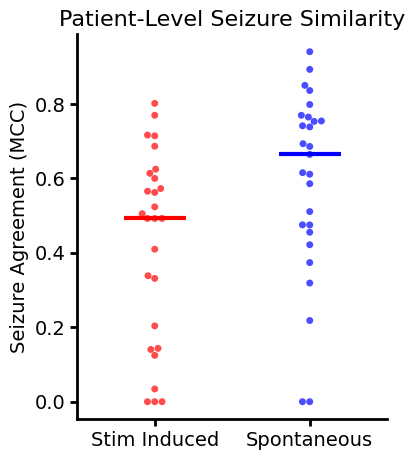

In [ ]:
_ = plot_seizure_similarity(ch_spread_similarity_df,sz_level=False,agreement='MCC')

In [ ]:
def plot_ks_similarity(data,palette = ['red','blue','purple']):
    def ks_function(group):
        stat,p = sc.stats.kstest(group[group.spont == False].F1,group[group.spont].F1)
        return pd.DataFrame(np.array([p,p < 0.05,stat,group.patient.to_list()[0]]).reshape(1,-1),columns=['pvalue','sig','KS','patient'])
    
    plot_data = data.groupby('patient').apply(ks_function)
    plot_data.loc[:,'pvalue'] = plot_data.loc[:,'pvalue'].astype(float)
    plot_data.loc[:,'sig'] = plot_data.loc[:,'sig'] == 'True'
    plot_data.loc[:,'KS'] = plot_data.loc[:,'KS'].astype(float)

    ax = sns.pointplot(data=plot_data,y='pvalue',errorbar=None,
                markers="_",linestyles="none",
                color='purple',
                # color='black',
                estimator=np.median,
                linewidth=4,
                markersize=45,
                )
                
    # plt.setp(ax.lines, linewidth=20)
    sns.swarmplot(data=plot_data,
                y='pvalue',
                alpha=.7,
                palette = palette[:2],
                ax=ax,
                hue='sig'
                )
    sns.despine()


In [ ]:
ch_similarity_df = calculate_seizure_similarity(sz_annots,first_annot='ueo_chs_strict_mask',second_annot='ueo_chs_strict_mask',paired=True)

Skipped ['HUP229', 'HUP246'] due to insufficient spontaneous seizures


In [ ]:
# plot_ks_similarity(ch_similarity_df)

Paired t-test - p: 0.022750838388139585, d: -0.4918677801783624


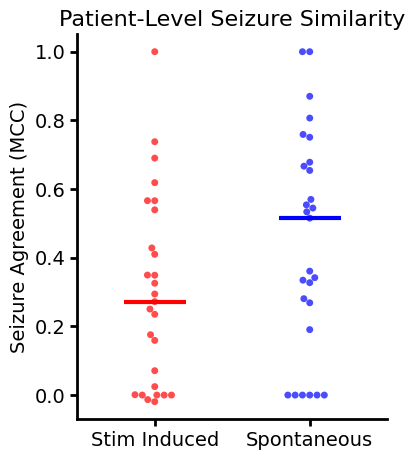

In [ ]:
fig = plot_seizure_similarity(ch_similarity_df,agreement='MCC',sz_level=False,typical=None)
# fig.savefig(ospj(figpath,"ch_sz_similarity.pdf"))

In [ ]:
all_stim_annots = []
all_spont_annots = []
annot_type = 'ueo'
con_type = 'loose'
example_pt = 'HUP257'
group = sz_annots[sz_annots.patient == example_pt]
group.sort_values(ascending=False,by='stim',inplace=True)
kappa_mat = np.zeros((len(group),len(group))); kappa_mat[:] = np.nan
group.reset_index(drop=True,inplace=True)
for i in range(len(group)):
    ch_mask = group.loc[i,f'{annot_type}_chs_{con_type}_mask']
    if group.loc[i,'stim'] == 1:
        print(f"{i} is stim")
    for j in range(i+1,len(group)):
        ch_mask2 = group.loc[j,f'{annot_type}_chs_{con_type}_mask']
        kappa_mat[i,j] = cohen_kappa_score(ch_mask,ch_mask2)

0 is stim


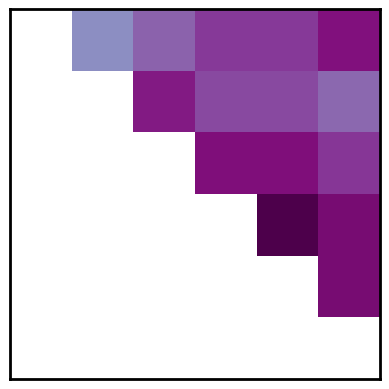

In [ ]:
import matplotlib.patches as patches
plt.imshow(kappa_mat,cmap = 'BuPu')
# plt.colorbar()
plt.clim(0,1)
plt.xticks([])
plt.yticks([])

plt.savefig(ospj(figpath,f'ueo_heatmap_pt-{example_pt}.pdf'),bbox_inches='tight')

### Seizure -- region

In [ ]:
sz_annots_rs = sz_annots.dropna(axis=0,subset=['all_rs'])

In [ ]:
sz_annots_rs

,patient,iEEG_ID,model,stim,approximate_onset,offset,threshold,ueo_chs_strict,ueo_chs_loose,sec_chs_strict,...,ueo_rs_strict,ueo_chs_loose_mask,ueo_rs_loose_mask,ueo_rs_loose,sec_chs_strict_mask,sec_rs_strict_mask,sec_rs_strict,sec_chs_loose_mask,sec_rs_loose_mask,sec_rs_loose
0,CHOP026,CHOP026,LSTM,0.0,771.890,797.89,1.606020,[LO03],"[LO03, LO04]","[LM01, LM02, LM03, LM04, LN01, LN02, LN03, LN0...",...,[Left-Hippocampus],"[False, False, False, False, False, False, Fal...","[False, True, False, False, False, False, Fals...","[Left-Hippocampus, Left-Hippocampus]","[False, False, False, False, False, False, Fal...","[True, True, False, False, False, False, False...","[Left-Amygdala, Left-Amygdala, Left-Amygdala, ...","[False, False, False, False, False, False, Fal...","[True, True, False, False, False, False, False...","[Left-Amygdala, Left-Amygdala, Left-Amygdala, ..."
1,HUP229,HUP229_phaseII,LSTM,1.0,1109.400,1176.91,3.588785,"[LA02, LA03, LB01, LB02, LB03, LB04, LC01, LC0...","[LA02, LA03, LA04, LB01, LB02, LB03, LB04, LB0...","[LA01, LA02, LA03, LB01, LB02, LB03, LB04, LC0...",...,"[ left amygdala , left hippocampus , left hi...","[False, False, True, True, False, False, False...","[True, True, False, True, True, False, True, F...","[ left amygdala , left superior temporal , l...","[False, False, False, True, False, True, False...","[True, True, True, True, True, False, True, Fa...","[ left amygdala , left amygdala , left hippo...","[False, False, True, True, False, True, True, ...","[True, True, True, True, True, False, True, Fa...","[ left amygdala , left amygdala , left super..."
2,CHOP035,CHOPCCEP_035,LSTM,1.0,2872.350,2899.06,3.097463,"[LM01, LM02, LM03, LM04, LN01, LN05, LN06, LL0...","[LG01, LG02, LG03, LG04, LG05, LL01, LL02, LL0...","[LM01, LM02, LM03, LN01, LN05, LN06, LL01, LL0...",...,"[ctx-lh-parahippocampal, ctx-lh-insula, ctx-lh...","[False, False, False, False, False, False, Tru...","[True, True, True, False, False, True, True, F...","[ctx-lh-parahippocampal, ctx-lh-insula, ctx-lh...","[False, False, False, False, False, False, Tru...","[True, True, False, False, False, True, True, ...","[ctx-lh-parahippocampal, ctx-lh-insula, Left-A...","[False, False, False, False, False, False, Tru...","[True, True, False, False, False, True, True, ...","[ctx-lh-parahippocampal, ctx-lh-insula, ctx-lh..."
3,CHOP026,CHOPCCEP_026,LSTM,1.0,3608.770,3742.56,2.841121,[],[],[LH05],...,[ctx-lh-parsopercularis],"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",[ctx-lh-parsopercularis],"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",[ctx-lh-parsopercularis],"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...",[ctx-lh-parsopercularis]
4,HUP230,HUP230_phaseII,LSTM,1.0,3860.240,3878.40,2.189586,"[LC01, LC02]","[LC01, LC02, LC03]","[LC01, LC02, LM04]",...,"[ left superior temporal , left parahippocamp...","[True, False, False, False, False, False, Fals...","[False, False, True, False, False, False, Fals...","[ left superior temporal , left parahippocamp...","[True, False, False, False, False, False, Fals...","[False, False, True, False, False, False, Fals...","[ left superior temporal , left parahippocamp...","[True, False, False, False, False, False, Fals...","[False, False, True, False, False, False, Fals...","[ left superior temporal , left parahippocamp..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,HUP247,HUP247_phaseII,LSTM,0.0,577555.030,577574.76,1.436582,"[RP01, RP02, RP03, RP04, RV04, RV05, RV07, RW0...","[RP01, RP02, RP03, RP04, RP05, RV04, RV05, RV0...","[RP01, RP02, RP03, RP04, RV04, RV05, RV06, RV0...",...,"[ right precuneus , right precuneus , right ...","[False, True, False, False, False, True, False...","[True, True, False, True, False, False, False]","[ right precuneus , right precuneus , right ...","[False, True

In [ ]:
r_similarity_df = calculate_seizure_similarity(sz_annots_rs,first_annot='ueo_rs_loose_mask',second_annot='ueo_rs_loose_mask')

Skipped ['HUP229', 'HUP246'] due to insufficient spontaneous seizures


Paired t-test - p: 0.011907390893827113, d: -0.5342012771300666


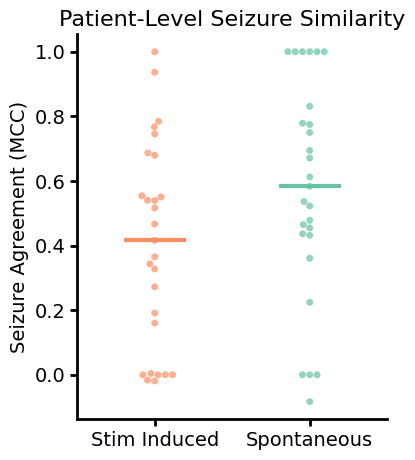

In [ ]:
fig = plot_seizure_similarity(r_similarity_df,agreement='MCC',palette=pal,sz_level=False,typical=None)
# fig.savefig(ospj(figpath,"region_sz_similarity.pdf"))

### Region spread

In [ ]:
r_spread_similarity_df = calculate_seizure_similarity(sz_annots_rs,first_annot='ueo_rs_loose_mask',second_annot='sec_rs_loose_mask')

Skipped ['HUP229', 'HUP246'] due to insufficient spontaneous seizures


Paired t-test - p: 0.19924564312725468, d: -0.3162798782316129


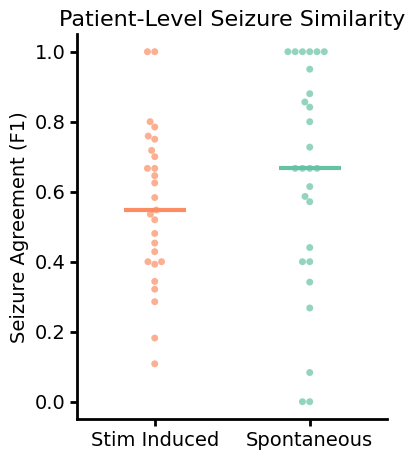

In [ ]:
fig = plot_seizure_similarity(r_spread_similarity_df,agreement='F1',palette=pal,sz_level=False)

### Bootstrapping

In [ ]:
# print(sz_annots_rs.iloc[-1,-1],sz_annots_rs.iloc[-1,8])

In [ ]:
# def boot_function(input_region,n_boots=1000):
#     np.random.seed(0)
#     seizure_counts = {}
#     n_boots = 1000
#     regions = np.atleast_1d(input_region).reshape(-1,)
#     # Perform 100 bootstraps
#     for _ in range(n_boots):
#         bootstrap_sample = np.random.choice(regions, size=len(regions), replace=True)
#         for region in np.unique(bootstrap_sample):
#             if region in seizure_counts:
#                 seizure_counts[region] += 1
#             else:
#                 seizure_counts[region] = 1

#     # Calculate the probability of each region being the true seizure region
#     probabilities = {region: count / n_boots for region, count in seizure_counts.items()}
#     most_likely = max(probabilities, key = probabilities.get) if len(probabilities)>0 else []
#     # return np.array([key for key in probabilities.keys() if probabilities[key] > 0.75])
#     return most_likely

# def mask_function(row):
#     return np.array([l in row.ueo_rs_boot for l in np.atleast_1d(row.all_rs)])
    

In [ ]:
# sz_annots_rs['ueo_rs_boot'] = sz_annots_rs['ueo_rs_strict'].apply(boot_function)

In [ ]:
# def surgical_parcelate(region_list):
#     surgical_labels = []
#     for label in np.atleast_1d(region_list):
#         if isinstance(label,float):
#             label = "EmptyLabel"
#         label = label.lower()
#         if ("emptylabel" in label) or ("white" in label):
#             surgical_label = "EmptyLabel"
#         elif ("amygdala" in label) or ("hippocampus" in label):
#             if "left" in label:
#                 surgical_label = 'left mesial temporal'
#             else:
#                 surgical_label = 'right mesial temporal'
#         elif ("temporal" in label) or ("fusiform" in label) or ("entorhinal" in label) or ("parahippocampal" in label):
#             if "left" in label:
#                 surgical_label = 'left temporal neocortex'
#             else:
#                 surgical_label = 'right temporal neocortex'
#         else:
#             if "left" in label:
#                 surgical_label = 'left other neocortex'
#             else:
#                 surgical_label = 'right other neocortex'
#         surgical_labels.append(surgical_label)
#     return surgical_labels

In [ ]:
# sz_annots_rs['ueo_rs_boot_mask'] = sz_annots_rs.apply(mask_function,axis=1)

In [ ]:
# boot_similarity_df = calculate_seizure_similarity(sz_annots_rs,first_annot='ueo_rs_boot_mask',second_annot='ueo_rs_boot_mask')

In [ ]:
# plot_seizure_similarity(boot_similarity_df,agreement='F1',palette=pal,sz_level=False, binary=True)

## Seizure spread timing

### Channels

In [ ]:
time_points =  np.arange(0,61,1)
def calculate_fraction(seizure_times, time_points = np.arange(0,60.5,.5)):
    fractions = []
    num_channels = seizure_times.shape[1]
    for t in time_points:
        fraction_seizing = (np.sum((seizure_times <= t) & (seizure_times >=0), axis=1)-np.sum(seizure_times < 0,axis=1)) / (num_channels-np.sum(seizure_times < 0,axis=1))
        fractions.append(fraction_seizing)
    return np.array(fractions).T  # Transpose to have seizures as rows and time points as columns

In [ ]:
# Now need to iterate through patinets, then iterate through seizures that are stim
all_pts = []
all_fraction_ts = []
for pt,group in sz_annots.groupby("patient"):
    stim_szs = group[group.stim == 1]
    spont_szs = group[group.stim == 0]
    for idx,st_sz in stim_szs.iterrows():
        # Now, for each stim seizure I want to iterate through each spontaneous seizure:
        onset_locs = st_sz.ueo_chs_strict # can change to other channel types but this makes the most sense
        if len(onset_locs.shape) == 0:
            onset_locs = np.array([str(onset_locs)])
        all_st_sp_spreads = np.ones((len(spont_szs),len(onset_locs)))*60000
        for j,(idx,sp_sz) in enumerate(spont_szs.iterrows()):
            # For each spontaneous seizure, find the time when the stim seizure onset regions start seizing (if ever)
            locs = sp_sz.sz_chs
            times = sp_sz.sz_times
            # all_pts.append(pt) # SEIZURE LEVEL
            for k,st_loc in enumerate(onset_locs):
                loc_idx = st_loc == locs
                if (loc_idx is not pd.NA) and (np.sum(loc_idx) > 0):
                    all_st_sp_spreads[j,k] = times[loc_idx]
            # This gives me an array that is spont seizures x stim onset channels and each element is the time that the spont seizure started seizing in that stim onset channel
            # I can try averaging across stim onset times for those that it started seizing in?
            # I can also just treat it as an independent data point to plot
        fraction_ts = calculate_fraction(all_st_sp_spreads,time_points)
        # all_fraction_ts.append(fraction_ts) # SEIZURE LEVEL
        all_pts.append(pt)
        all_fraction_ts.append(np.mean(fraction_ts,axis=0))

stim_spread_df = pd.DataFrame(np.array(all_fraction_ts),columns=time_points)
nan_idxs = stim_spread_df.isna().any(axis=1)
stim_spread_df = stim_spread_df.loc[~nan_idxs,:]
stim_spread_df_b = (stim_spread_df > 0.0).astype(float)
# stim_spread_df = pd.DataFrame(np.concatenate(all_fraction_ts,axis=0),columns=time_points) # SEIZURE LEVEL
stim_spread_df['patient'] = np.array(all_pts)[~nan_idxs]
stim_spread_df_b['patient'] = np.array(all_pts)[~nan_idxs]

stim_spread_df_long_b = stim_spread_df_b.melt(id_vars=['patient'], var_name='Time', value_name='Fraction')
stim_spread_df_long = stim_spread_df.melt(id_vars=['patient'], var_name='Time', value_name='Fraction')

In [ ]:
np.array(all_pts)[~nan_idxs]

array(['CHOP005', 'CHOP024', 'CHOP026', 'CHOP026', 'CHOP026', 'CHOP026',
       'CHOP028', 'CHOP028', 'CHOP035', 'CHOP035', 'CHOP037', 'CHOP037',
       'CHOP041', 'CHOP044', 'CHOP045', 'CHOP049', 'HUP224', 'HUP225',
       'HUP229', 'HUP230', 'HUP235', 'HUP238', 'HUP246', 'HUP247',
       'HUP249', 'HUP250', 'HUP253', 'HUP257', 'HUP261', 'HUP263',
       'HUP266', 'HUP266', 'HUP266', 'HUP267', 'HUP273', 'HUP273',
       'HUP275', 'HUP275', 'HUP288'], dtype='<U7')

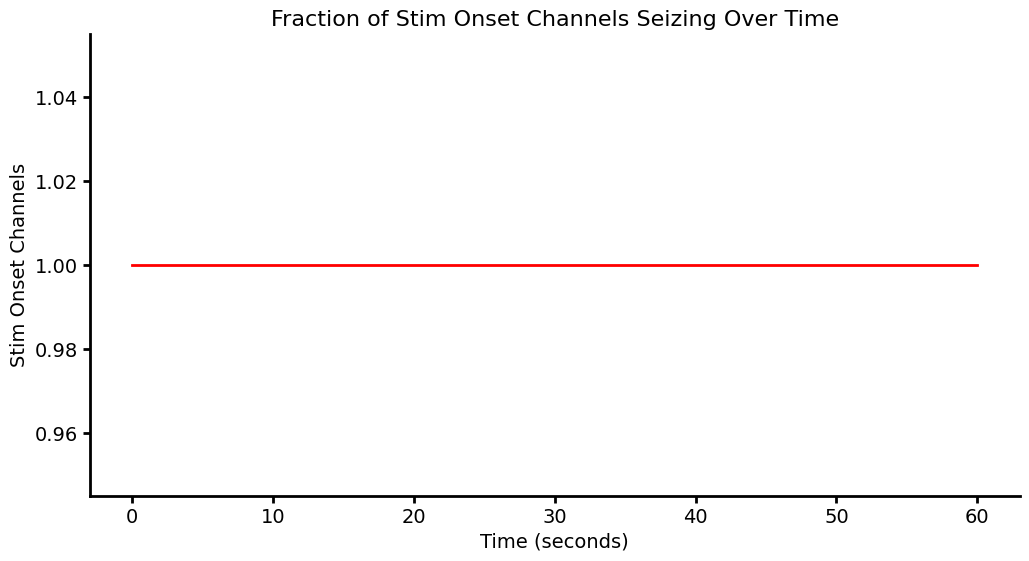

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=stim_spread_df_long_b, x='Time', y='Fraction',color='red')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 0]['Fraction'].mean(),color='red',linestyle='--')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 15]['Fraction'].mean(),color='blue',linestyle='--')
plt.title('Fraction of Stim Onset Channels Seizing Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Stim Onset Channels')
sns.despine()
# plt.ylim((0,1))

#### Null modeling

Need to figure out what are the odds of a random selection of regions equal to the number of stim onset regions seizing at that time point. This should sample from the all_rs based on the number of stim UEO regions

In [ ]:
set_seed(2358)
# Now need to iterate through patinets, then interate through seizures that are stim
all_pts = []
null_fraction_ts = []
for pt,group in sz_annots.groupby("patient"):
    stim_szs = group[group.stim == 1]
    spont_szs = group[group.stim == 0]
    for idx,st_sz in stim_szs.iterrows():
        onset_locs = st_sz.ueo_chs_strict # can change to other channel types but this makes the most sense
        if len(onset_locs.shape) == 0:
            onset_locs = np.array([str(onset_locs)])
        null_n = len(onset_locs)
        for _ in range(50):
            if null_n == 0:
                null_locs = []
            else:
                sample_chs = np.array([r for r in np.atleast_1d(st_sz.all_channels)])
                null_locs = sample_chs[np.random.randint(0,len(sample_chs),null_n)]
            null_st_sp_spreads = np.ones((len(spont_szs),len(null_locs)))*60000
            for j,(idx,sp_sz) in enumerate(spont_szs.iterrows()):
                # For each spontaneous seizure, find the time when the stim seizure onset regions start seizing (if ever)
                locs = sp_sz.sz_chs
                times = sp_sz.sz_times
                # all_pts.append(pt) # SEIZURE LEVEL
                for k,st_loc in enumerate(null_locs):
                    loc_idx = st_loc == locs
                    if (loc_idx is not pd.NA) and (np.sum(loc_idx) > 0):
                        null_st_sp_spreads[j,k] = times[loc_idx]
            fraction_ts = calculate_fraction(null_st_sp_spreads,time_points)
            # null_fraction_ts.append(fraction_ts) # SEIZURE LEVEL
            null_fraction_ts.append(np.mean(fraction_ts,axis=0))
            all_pts.append(pt) 
null_spread_df = pd.DataFrame(np.array(null_fraction_ts),columns=time_points)
null_spread_df_b = (null_spread_df > 0.0).astype(float)
# null_spread_df = pd.DataFrame(np.concatenate(null_fraction_ts,axis=0),columns=time_points) # SEIZURE LEVEL
null_spread_df['patient'] = all_pts
null_spread_df_b['patient'] = all_pts
null_spread_df_long = null_spread_df.melt(id_vars=['patient'], var_name='Time', value_name='Fraction')
null_spread_df_long_b = null_spread_df_b.melt(id_vars=['patient'], var_name='Time', value_name='Fraction')

In [ ]:
is_sig = np.zeros((len(time_points),),dtype=bool)
for i,t in enumerate(time_points):
    stim_dist = stim_spread_df_long_b[stim_spread_df_long_b.Time == t]['Fraction']
    null_dist = null_spread_df_long_b[null_spread_df_long_b.Time == t]['Fraction']
    # pval = sc.stats.ttest_ind(stim_dist,null_dist,alternative='greater')[1]
    pval = (np.sum(null_dist > np.mean(stim_dist))+1)/(len(null_dist)+1)
    print(pval)
    if pval < 0.05:
        is_sig[i] = True


0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.00048756704046806434
0.000487567

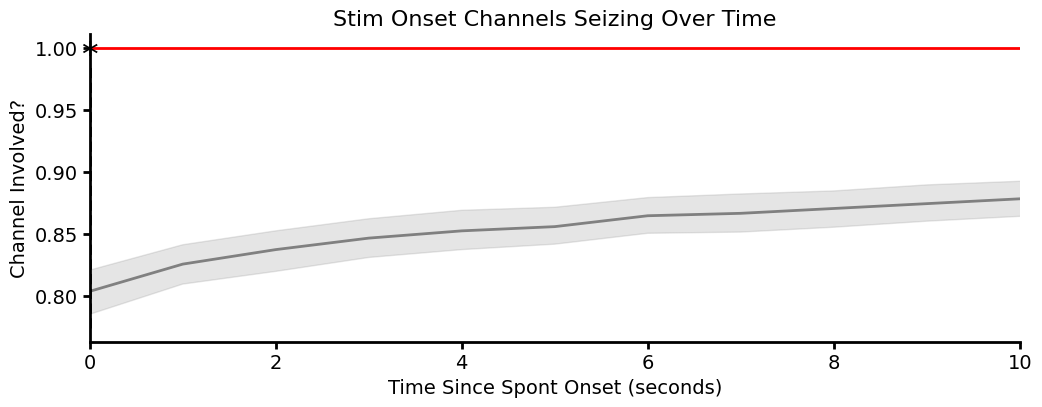

In [ ]:
fig,ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data=stim_spread_df_long_b, x='Time', y='Fraction',color='red')
sns.lineplot(data=null_spread_df_long_b, x='Time', y='Fraction',color='grey')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 0]['Fraction'].mean(),color='red',linestyle='--')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 15]['Fraction'].mean(),color='blue',linestyle='--')
plt.title('Stim Onset Channels Seizing Over Time')
plt.xlabel('Time Since Spont Onset (seconds)')
plt.ylabel('Channel Involved?')
sns.despine()
plt.xlim((0,10))
# plt.ylim((.8,1.05))
# for i in range(len(is_sig) - 1):
#     if is_sig[i]:
#         if is_sig[i + 1]:
#             ax.hlines(1, time_points[i], time_points[i + 1], color='k', linewidth=2)
#         else:
#             ax.hlines(1, time_points[i], time_points[i], color='k', linewidth=2)
star_x = np.where(is_sig)[0][0]
ymin,ymax = plt.ylim()
plt.text(time_points[star_x],ymax-.025,'*',fontsize='24',horizontalalignment='center')
plt.vlines(time_points[star_x],ymin,ymax-.025,ls='--',color='k')
plt.savefig(ospj(figpath,'stim_ueo_ch_recruitment.pdf'),bbox_inches='tight')

(0.0, 10.0)

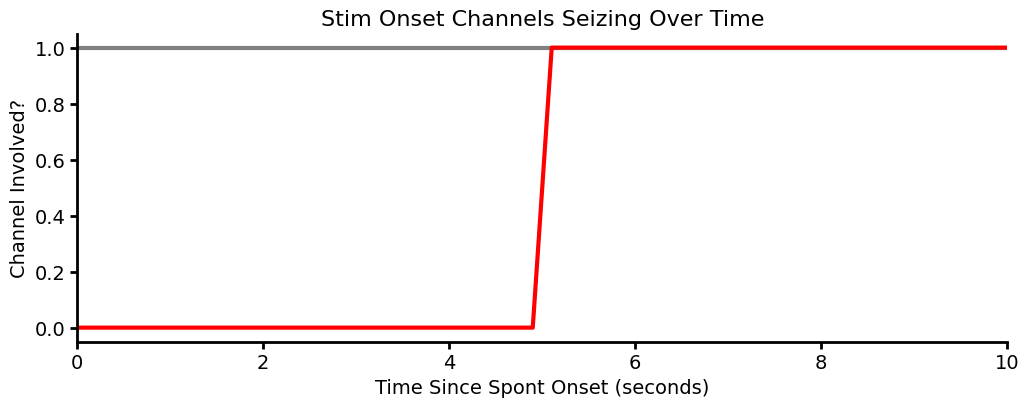

In [ ]:
fig,ax = plt.subplots(figsize=(12, 4))
plot_x = np.linspace(0,10,50)
plot_y = np.ones((50,))
plt.plot(plot_x,plot_y,color='grey',linewidth=3)
plot_y[plot_x < 5] = 0
plt.plot(plot_x,plot_y,color='red',linewidth=3)
plt.title('Stim Onset Channels Seizing Over Time')
plt.xlabel('Time Since Spont Onset (seconds)')
plt.ylabel('Channel Involved?')
sns.despine()
plt.xlim((0,10))

#### Calculating recruitment speed

In [ ]:
# null_speed_df = null_spread_df_b.iloc[:,:-1].diff(axis=1)
# null_speed_df['patient'] = null_spread_df.patient
# null_speed_df_long = null_speed_df.melt(id_vars=['patient'], var_name='Time', value_name='Fraction')

# stim_speed_df = stim_spread_df_b.iloc[:,:-1].diff(axis=1)
# stim_speed_df['patient'] =stim_spread_df.patient
# stim_speed_df_long = stim_speed_df.melt(id_vars=['patient'], var_name='Time', value_name='Fraction')

In [ ]:
# is_sig = np.zeros((int(21/1),),dtype=bool)
# for i,t in enumerate(np.arange(0,21,1)):
#     stim_dist = stim_speed_df_long[stim_speed_df_long.Time == t]['Fraction']
#     null_dist = null_speed_df_long[null_speed_df_long.Time == t]['Fraction']
#     # pval = sc.stats.ttest_ind(stim_dist,null_dist,alternative='greater')[1]
#     pval = (np.sum(null_dist > np.mean(stim_dist))+1)/(len(null_dist)+1)
#     print(pval)
#     if pval < 0.05:
#         is_sig[i] = True

In [ ]:
# fig,ax = plt.subplots(figsize=(12, 4))
# sns.lineplot(data=stim_speed_df_long, x='Time', y='Fraction',color='red',ax=ax)
# sns.lineplot(data=null_speed_df_long, x='Time', y='Fraction',color='grey',ax=ax)
# # plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 0]['Fraction'].mean(),color='red',linestyle='--')
# # plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 15]['Fraction'].mean(),color='blue',linestyle='--')
# plt.title('Stim Onset Channels Recruitment Speed Over Time')
# plt.xlabel('Time Since Spont Onset (seconds)')
# plt.ylabel('Frac. Recruited Ch/sec')
# sns.despine(ax=ax)
# plt.xlim((0,15))

# # Plot horizontal bars at y = 0.05
# for i in range(len(is_sig) - 1):
#     if is_sig[i]:
#         if is_sig[i + 1]:
#             ax.hlines(0.055, time_points[i], time_points[i + 1], color='k', linewidth=2)
#         else:
#             ax.hlines(0.055, time_points[i], time_points[i], color='k', linewidth=2)

# # plt.savefig(ospj(figpath,'stim_ueo_channel_recruitment_speed.pdf'),bbox_inches='tight')

#### Calculating fraction of onset regions at 5 seconds comparing null model to stim seizure onset to every other spontaneous seizure onset

In [ ]:
# Now need to iterate through patients, then interate through seizures that are stim
all_pts = []
spont_fraction_ts = []
for pt,group in sz_annots.groupby("patient"):
    spont_szs = group[group.stim == 0]
    print(pt)
    for idx,key_sz in spont_szs.iterrows():
        # Now, for each spontatneous seizure I want to iterate through each other spontaneous seizure:
        onset_locs = key_sz.ueo_chs_strict
        if len(onset_locs.shape) == 0:
            onset_locs = np.array([str(onset_locs)])
        
        all_st_sp_spreads = np.ones((len(spont_szs),len(onset_locs)))*60000
        for j,(idx,sp_sz) in enumerate(spont_szs.iterrows()):
            # For each spontaneous seizure, find the time when the stim seizure onset regions start seizing (if ever)
            locs = sp_sz.sz_chs
            times = sp_sz.sz_times
            for k,key_loc in enumerate(onset_locs):
                loc_idx = key_loc == locs
                if (loc_idx is not pd.NA) and (np.sum(loc_idx) > 0):
                    all_st_sp_spreads[j,k] = times[loc_idx]
        fraction_ts = calculate_fraction(all_st_sp_spreads,time_points)
        if np.isnan(fraction_ts).any():
            continue
        # spont_fraction_ts.append(fraction_ts)
        # all_pts.append([pt]*len(fraction_ts))
        spont_fraction_ts.append(np.nanmean(fraction_ts,axis=0))
        all_pts.append(pt)

spont_spread_df = pd.DataFrame(np.array(spont_fraction_ts),columns=time_points)
spont_spread_df_b = spont_spread_df > 0.05
spont_spread_df['patient'] = all_pts
spont_spread_df_b['patient'] = all_pts
spont_spread_df_long_b = spont_spread_df_b.melt(id_vars=['patient'], var_name='Time', value_name='Fraction')
spont_spread_df_long = spont_spread_df.melt(id_vars=['patient'], var_name='Time', value_name='Fraction')

CHOP005
CHOP024
CHOP026
CHOP028
CHOP035
CHOP037
CHOP041
CHOP044
CHOP045
CHOP049
HUP224
HUP225
HUP229
HUP230
HUP235
HUP238
HUP246
HUP247
HUP249
HUP250
HUP253
HUP257
HUP261
HUP263
HUP266
HUP267
HUP273
HUP275
HUP288


In [ ]:
is_sig = np.zeros((int(60/1),),dtype=bool)
for i,t in enumerate(np.arange(0,60,1)):
    spont_dist = spont_spread_df_long[spont_spread_df_long.Time == 0]['Fraction']
    stim_dist = stim_spread_df_long[stim_spread_df_long.Time == t]['Fraction']
    pval = sc.stats.ttest_ind(spont_dist,stim_dist,alternative='greater')[1]
    if pval < 0.05:
        is_sig[i] = True

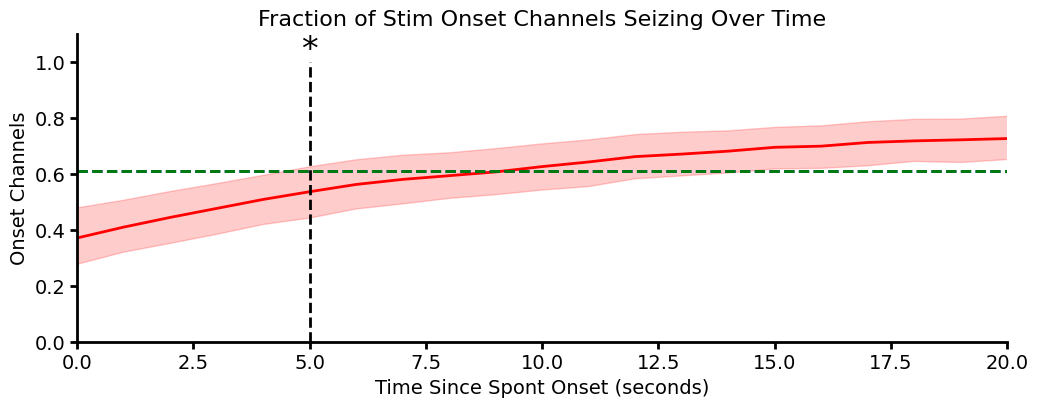

In [ ]:
fig,ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data=stim_spread_df_long, x='Time', y='Fraction',color='red',linewidth=2,err_style='band')
# sns.lineplot(data=spont_spread_df_long, x='Time', y='Fraction',color='green',linewidth=2,err_style='band')
plotting_df = spont_spread_df_long.copy()
plotting_df = plotting_df[plotting_df.Time==0]
plotting_df.loc[:,'Time'] = -2
# sns.lineplot(data=null_spread_df_long, x='Time', y='Fraction',color='grey',linewidth=2)
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 0]['Fraction'].mean(),color='red',linestyle='--')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 15]['Fraction'].mean(),color='blue',linestyle='--')
plt.title('Fraction of Stim Onset Channels Seizing Over Time')
plt.xlabel('Time Since Spont Onset (seconds)')
plt.ylabel('Onset Channels')
sns.despine()
plt.xlim((0,20))
plt.ylim((0,1.1))
# Plot horizontal bars at y = 0.05
# for i in range(len(is_sig) - 1):
#     if is_sig[i]:
#         if is_sig[i + 1]:
#             ax.hlines(1, time_points[i], time_points[i + 1], color='k', linewidth=2)
#         else:
#             ax.hlines(1, time_points[i], time_points[i], color='k', linewidth=2)
star_x = np.where(is_sig)[0][-1]
plt.hlines(spont_spread_df_long[spont_spread_df_long.Time == 0]['Fraction'].mean(),0,60,colors='blue',linestyles='--',linewidth=2)
plt.text(time_points[star_x],1.01,'*',fontsize='24',horizontalalignment='center')
ymin,ymax = plt.ylim()
plt.vlines(time_points[star_x],ymin,1,ls='--',color='k')
plt.hlines(spont_spread_df_long[spont_spread_df_long.Time == 0]['Fraction'].mean(),0,60,colors='green',linestyles='--',linewidth=2)
plt.savefig(ospj(figpath,'spont-stim_ueo_channel_recruitment.pdf'),bbox_inches='tight')

### Regions

Goal is to create a lineplot with error bar that has the percent of the stim seizure onset zone channels recruited on the y axis and the time since onset on the x axis.
For each stim seizure I need to create that signal. Really i'll have a signal for each stim-spont pair
If I have the time varying % seizing signal for each stim-spont pair I can calculate average across time for a stim seizure
Need to change each 
For each stim seizure:
    extract stim seizure onset zones
    For each spontaneous seizure in the same patient:
        Save time when each of the stim seizure onset regions started seizing in spontaneous seizure

In [ ]:
# Converting the sz_chs into sz_rs
def ch2r(row,electrode_regions):
    sz_chs = row.sz_chs
    sz_times = row.sz_times
    electrode_locals = np.array([l for l in electrode_regions[electrode_regions.name.isin(sz_chs)]['label']])
    sz_locs = []
    sz_loc_times = []
    for loc in np.unique(electrode_locals):
        loc_inds = loc == electrode_locals
        loc_times = sz_times[loc_inds]
        sz_loc_times.append(min(loc_times))
        sz_locs.append(loc)
    row.sz_locs = np.array(sz_locs)
    row.sz_loc_times = np.array(sz_loc_times)
    return row
        
sz_annots_rs[["sz_locs","sz_loc_times"]] = pd.NA
for pt,group in sz_annots_rs.groupby("patient"):
    region_path = get_rpath(prodatapath,pt)
    electrode_regions = pd.read_pickle(region_path)
    # electrode_regions = surgical_parcellation(electrode_regions)
    group = group.apply(lambda x: ch2r(x,electrode_regions),axis=1)
    sz_annots_rs.loc[group.index,["sz_locs","sz_loc_times"]] = group.loc[:,["sz_locs","sz_loc_times"]]

In [ ]:
time_points =  np.arange(0,60.5,.5)
def calculate_fraction(seizure_times, time_points = np.arange(0,60.5,.5)):
    fractions = []
    num_channels = seizure_times.shape[1]
    for t in time_points:
        fraction_seizing = (np.sum((seizure_times <= t) & (seizure_times >=0), axis=1)-np.sum(seizure_times < 0,axis=1)) / (num_channels-np.sum(seizure_times < 0,axis=1))
        fractions.append(fraction_seizing)
    return np.array(fractions).T  # Transpose to have seizures as rows and time points as columns

In [ ]:
# Now need to iterate through patinets, then iterate through seizures that are stim
all_pts = []
all_fraction_ts = []
for pt,group in sz_annots_rs.groupby("patient"):
    stim_szs = group[group.stim == 1]
    spont_szs = group[group.stim == 0]
    for idx,st_sz in stim_szs.iterrows():
        # Now, for each stim seizure I want to iterate through each spontaneous seizure:
        onset_locs = st_sz.ueo_rs_strict # can change to other channel types but this makes the most sense
        if len(onset_locs.shape) == 0:
            onset_locs = np.array([str(onset_locs)])
        all_st_sp_spreads = np.ones((len(spont_szs),len(onset_locs)))*60000
        for j,(idx,sp_sz) in enumerate(spont_szs.iterrows()):
            # For each spontaneous seizure, find the time when the stim seizure onset regions start seizing (if ever)
            locs = sp_sz.sz_locs
            times = sp_sz.sz_loc_times
            # all_pts.append(pt) # SEIZURE LEVEL
            for k,st_loc in enumerate(onset_locs):
                loc_idx = st_loc == locs
                if (loc_idx is not pd.NA) and (np.sum(loc_idx) > 0):
                    all_st_sp_spreads[j,k] = times[loc_idx]
            # This gives me an array that is spont seizures x stim onset channels and each element is the time that the spont seizure started seizing in that stim onset channel
            # I can try averaging across stim onset times for those that it started seizing in?
            # I can also just treat it as an independent data point to plot
        fraction_ts = calculate_fraction(all_st_sp_spreads)
        # all_fraction_ts.append(fraction_ts) # SEIZURE LEVEL
        all_pts.append(pt)
        all_fraction_ts.append(np.mean(fraction_ts,axis=0))
stim_spread_df = pd.DataFrame(np.array(all_fraction_ts),columns=time_points)
# stim_spread_df = (stim_spread_df>0.5).astype(float)
# stim_spread_df = pd.DataFrame(np.concatenate(all_fraction_ts,axis=0),columns=time_points) # SEIZURE LEVEL
nan_idxs = stim_spread_df.isna().any(axis=1)
stim_spread_df = stim_spread_df.loc[~nan_idxs,:]
stim_spread_df['patient'] = np.array(all_pts)[~nan_idxs]
stim_spread_df_long = stim_spread_df.melt(id_vars=['patient'], var_name='Time', value_name='Fraction')


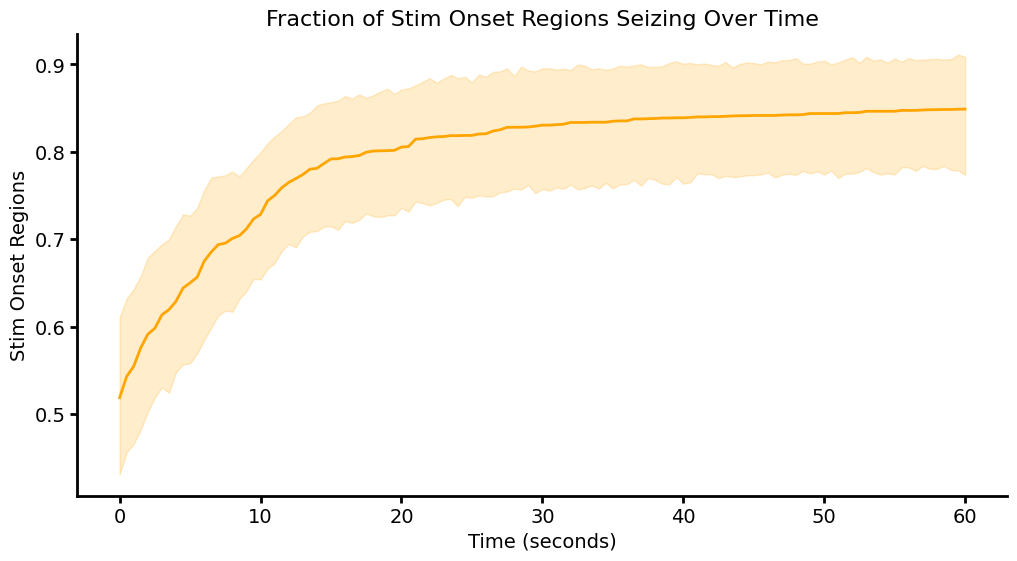

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=stim_spread_df_long, x='Time', y='Fraction',color='orange')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 0]['Fraction'].mean(),color='red',linestyle='--')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 15]['Fraction'].mean(),color='blue',linestyle='--')
plt.title('Fraction of Stim Onset Regions Seizing Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Stim Onset Regions')
sns.despine()
# plt.ylim((0,1))

#### Null modeling

Need to figure out what are the odds of a random selection of regions equal to the number of stim onset regions seizing at that time point. This should sample from the all_rs based on the number of stim UEO regions

In [ ]:
set_seed(2358)
# Now need to iterate through patinets, then interate through seizures that are stim
all_pts = []
null_fraction_ts = []
for pt,group in sz_annots_rs.groupby("patient"):
    stim_szs = group[group.stim == 1]
    spont_szs = group[group.stim == 0]
    for idx,st_sz in stim_szs.iterrows():
        onset_locs = st_sz.ueo_rs_strict # can change to other channel types but this makes the most sense
        if len(onset_locs.shape) == 0:
            onset_locs = np.array([str(onset_locs)])
        null_n = len(onset_locs)
        for _ in range(50):
            if null_n == 0:
                null_locs = []
            else:
                sample_rs = np.array([r for r in np.atleast_1d(st_sz.all_rs) if r != 'EmptyLabel'])
                null_locs = sample_rs[np.random.randint(0,len(sample_rs),null_n)]
            null_st_sp_spreads = np.ones((len(spont_szs),len(null_locs)))*60000
            for j,(idx,sp_sz) in enumerate(spont_szs.iterrows()):
                # For each spontaneous seizure, find the time when the stim seizure onset regions start seizing (if ever)
                locs = sp_sz.sz_locs
                times = sp_sz.sz_loc_times
                # all_pts.append(pt) # SEIZURE LEVEL
                for k,st_loc in enumerate(null_locs):
                    loc_idx = st_loc == locs
                    if (loc_idx is not pd.NA) and (np.sum(loc_idx) > 0):
                        null_st_sp_spreads[j,k] = times[loc_idx]
            fraction_ts = calculate_fraction(null_st_sp_spreads)
            # null_fraction_ts.append(fraction_ts) # SEIZURE LEVEL
            null_fraction_ts.append(np.mean(fraction_ts,axis=0))
            all_pts.append(pt) 
null_spread_df = pd.DataFrame(np.array(null_fraction_ts),columns=time_points)
# null_spread_df = (null_spread_df > 0.5).astype(float)
# null_spread_df = pd.DataFrame(np.concatenate(null_fraction_ts,axis=0),columns=time_points) # SEIZURE LEVEL
null_spread_df['patient'] = all_pts
null_spread_df_long = null_spread_df.melt(id_vars=['patient'], var_name='Time', value_name='Fraction')

In [ ]:
is_sig = np.zeros((int(60.5/0.5),),dtype=bool)
for i,t in enumerate(np.arange(0,60.5,0.5)):
    stim_dist = stim_spread_df_long[stim_spread_df_long.Time == t]['Fraction']
    null_dist = null_spread_df_long[null_spread_df_long.Time == t]['Fraction']
    pval = sc.stats.ttest_ind(stim_dist,null_dist,alternative='greater')[1]
    if pval < 0.05:
        is_sig[i] = True

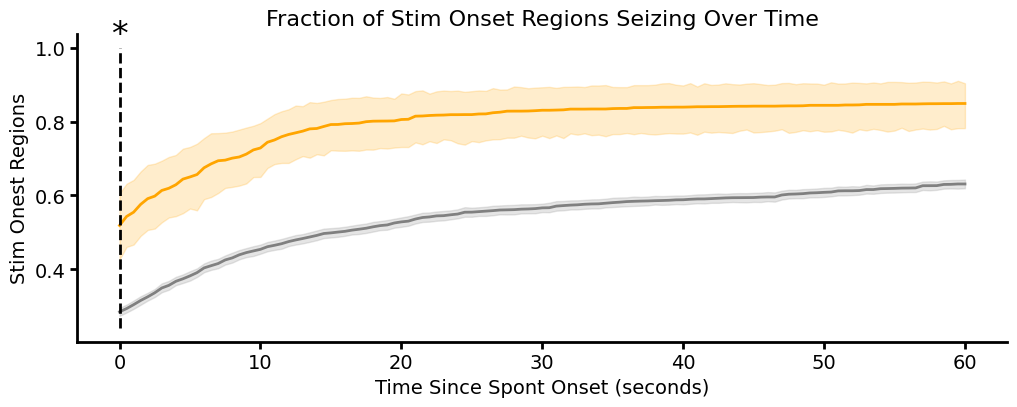

In [ ]:
fig,ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data=stim_spread_df_long, x='Time', y='Fraction',color='orange')
sns.lineplot(data=null_spread_df_long, x='Time', y='Fraction',color='grey')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 0]['Fraction'].mean(),color='red',linestyle='--')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 15]['Fraction'].mean(),color='blue',linestyle='--')
plt.title('Fraction of Stim Onset Regions Seizing Over Time')
plt.xlabel('Time Since Spont Onset (seconds)')
plt.ylabel('Stim Onest Regions')
sns.despine()
# plt.xlim((0,15))
# plt.ylim((0,1))
# Plot horizontal bars at y = 0.05
# for i in range(len(is_sig) - 1):
#     if is_sig[i]:
#         if is_sig[i + 1]:
#             ax.hlines(1, time_points[i], time_points[i + 1], color='k', linewidth=2)
#         else:
#             ax.hlines(1, time_points[i], time_points[i], color='k', linewidth=2)
star_x = np.where(is_sig)[0][0]
plt.text(time_points[star_x],1.01,'*',fontsize='24',horizontalalignment='center')
ymin,ymax = plt.ylim()
plt.vlines(time_points[star_x],ymin,1,ls='--',color='k')
plt.savefig(ospj(figpath,'stim_ueo_region_recruitment.pdf'),bbox_inches='tight')

#### Calculating recruitment speed

In [ ]:
# null_speed_df = null_spread_df.iloc[:,:-1].diff(axis=1)
# null_speed_df['patient'] = null_spread_df.patient
# null_speed_df_long = null_speed_df.melt(id_vars=['patient'], var_name='Time', value_name='Fraction')

# stim_speed_df = stim_spread_df.iloc[:,:-1].diff(axis=1)
# stim_speed_df['patient'] =stim_spread_df.patient
# stim_speed_df_long = stim_speed_df.melt(id_vars=['patient'], var_name='Time', value_name='Fraction')

In [ ]:
# is_sig = np.zeros((int(20/0.5),),dtype=bool)
# for i,t in enumerate(np.arange(0,20.5,0.5)):
#     stim_dist = stim_speed_df_long[stim_speed_df_long.Time == t]['Fraction']
#     null_dist = null_speed_df_long[null_speed_df_long.Time == t]['Fraction']
#     pval = sc.stats.ttest_ind(stim_dist,null_dist,alternative='greater')[1]
#     if pval < 0.05:
#         is_sig[i] = True

In [ ]:
# fig,ax = plt.subplots(figsize=(12, 4))
# sns.lineplot(data=stim_speed_df_long, x='Time', y='Fraction',color='orange',ax=ax)
# sns.lineplot(data=null_speed_df_long, x='Time', y='Fraction',color='grey',ax=ax)
# # plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 0]['Fraction'].mean(),color='red',linestyle='--')
# # plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 15]['Fraction'].mean(),color='blue',linestyle='--')
# plt.title('Stim Onset Regions Recruitment Speed Over Time')
# plt.xlabel('Time Since Spont Onset (seconds)')
# plt.ylabel('Frac. Recruited Regions/sec')
# sns.despine(ax=ax)
# plt.xlim((0,20))

# # Plot horizontal bars at y = 0.05
# for i in range(len(is_sig) - 1):
#     if is_sig[i]:
#         if is_sig[i + 1]:
#             ax.hlines(0.035, time_points[i], time_points[i + 1], color='k', linewidth=2)
#         else:
#             ax.hlines(0.035, time_points[i], time_points[i], color='k', linewidth=2)

# # plt.savefig(ospj(figpath,'stim_ueo_region_recruitment_speed.pdf'),bbox_inches='tight')

#### Calculating fraction of onset regions at 5 seconds comparing null model to stim seizure onset to every other spontaneous seizure onset

In [ ]:
# Now need to iterate through patients, then interate through seizures that are stim
all_pts = []
spont_fraction_ts = []
for pt,group in sz_annots_rs.groupby("patient"):
    spont_szs = group[group.stim == 0]
    print(pt)
    for idx,key_sz in spont_szs.iterrows():
        # Now, for each spontatneous seizure I want to iterate through each other spontaneous seizure:
        onset_locs = key_sz.ueo_rs_strict
        if len(onset_locs.shape) == 0:
            onset_locs = np.array([str(onset_locs)])
        
        all_st_sp_spreads = np.ones((len(spont_szs),len(onset_locs)))*60000
        for j,(idx,sp_sz) in enumerate(spont_szs.iterrows()):
            # For each spontaneous seizure, find the time when the stim seizure onset regions start seizing (if ever)
            locs = sp_sz.sz_locs
            times = sp_sz.sz_loc_times
            for k,key_loc in enumerate(onset_locs):
                loc_idx = key_loc == locs
                if (loc_idx is not pd.NA) and (np.sum(loc_idx) > 0):
                    all_st_sp_spreads[j,k] = times[loc_idx]
        fraction_ts = calculate_fraction(all_st_sp_spreads)
        if np.isnan(fraction_ts).any():
            continue
        # spont_fraction_ts.append(fraction_ts)
        # all_pts.append([pt]*len(fraction_ts))
        spont_fraction_ts.append(np.nanmean(fraction_ts,axis=0))
        all_pts.append(pt)

spont_spread_df = pd.DataFrame(np.array(spont_fraction_ts),columns=time_points)
# spont_spread_df = (spont_spread_df > 0.5).astype(float)
spont_spread_df['patient'] = all_pts
spont_spread_df_long = spont_spread_df.melt(id_vars=['patient'], var_name='Time', value_name='Fraction')

CHOP005
CHOP024
CHOP026
CHOP028
CHOP035
CHOP037
CHOP041
CHOP044
CHOP045
CHOP049
HUP224
HUP225
HUP229
HUP230
HUP235
HUP238
HUP246
HUP247
HUP249
HUP250
HUP253
HUP257
HUP261
HUP263
HUP266
HUP267
HUP273
HUP275
HUP288


In [ ]:
is_sig = np.zeros((int(60.5/0.5),),dtype=bool)
for i,t in enumerate(np.arange(0,60.5,0.5)):
    spont_dist = spont_spread_df_long[spont_spread_df_long.Time == 0]['Fraction']
    stim_dist = stim_spread_df_long[stim_spread_df_long.Time == t]['Fraction']
    pval = sc.stats.ttest_ind(spont_dist,stim_dist,alternative='greater')[1]
    if pval < 0.05:
        is_sig[i] = True

5.5


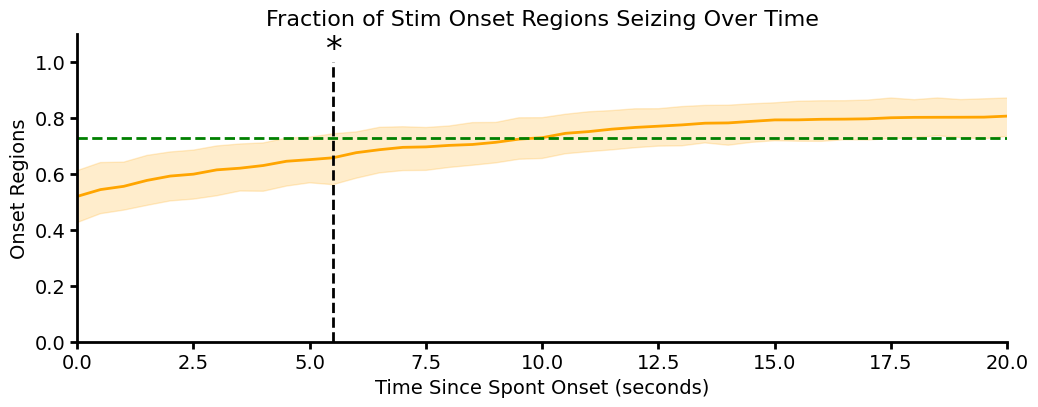

In [ ]:
fig,ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data=stim_spread_df_long, x='Time', y='Fraction',color='orange',linewidth=2,err_style='band')
# sns.lineplot(data=spont_spread_df_long, x='Time', y='Fraction',color='green',linewidth=2,err_style='band')
plotting_df = spont_spread_df_long.copy()
plotting_df = plotting_df[plotting_df.Time==0]
plotting_df.loc[:,'Time'] = -2
# sns.lineplot(data=null_spread_df_long, x='Time', y='Fraction',color='grey',linewidth=2)
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 0]['Fraction'].mean(),color='red',linestyle='--')
# plt.axhline(stim_spread_df_long[stim_spread_df_long.Time == 15]['Fraction'].mean(),color='blue',linestyle='--')
plt.title('Fraction of Stim Onset Regions Seizing Over Time')
plt.xlabel('Time Since Spont Onset (seconds)')
plt.ylabel('Onset Regions')
sns.despine()
plt.xlim((0,20))
plt.ylim((0,1.1))
# Plot horizontal bars at y = 0.05
# for i in range(len(is_sig) - 1):
#     if is_sig[i]:
#         if is_sig[i + 1]:
#             ax.hlines(1, time_points[i], time_points[i + 1], color='k', linewidth=2)
#         else:
#             ax.hlines(1, time_points[i], time_points[i], color='k', linewidth=2)
star_x = np.where(is_sig)[0][-1]
print(time_points[star_x])
plt.text(time_points[star_x],1.01,'*',fontsize='24',horizontalalignment='center')
ymin,ymax = plt.ylim()
plt.vlines(time_points[star_x],ymin,1,ls='--',color='k')
plt.hlines(spont_spread_df_long[spont_spread_df_long.Time == 0]['Fraction'].mean(),0,60,colors='green',linestyles='--',linewidth=2)
plt.savefig(ospj(figpath,'spont-stim_ueo_region_recruitment.pdf'),bbox_inches='tight')

## Predicting Stim Seizure Similarity

### Calculating seizure level metadata

Make a dataframe with the following columns: Patient, stim seizure, spontaneous seizure, stim onset regions, spontaneous onset regions, kappa, stim seizure duration, hippocampal localization? 

273 is atypical

In [ ]:
def model_seizure_similarity(annots,first_annot = 'ueo_consensus', second_annot = 'ueo_consensus',paired=True):
    annot_list = ["kappa","F1","patient","IEEGname","approximate_onset","stim_sz_length","stim_sz_spread"]
    annot_dict = {key:[] for key in annot_list}
    skip_pt = []
    for pt,group in annots.groupby("patient"):
        if (sum(group.stim == 0) < 2) and paired:
            skip_pt.append(pt)
            continue
        elif len(group) < 2:
            skip_pt.append(pt)
            continue
        # Iterate through each seizure
        for i in range(len(group)):
            group.reset_index(drop=True,inplace=True)
            ch_mask = group.loc[i,first_annot].reshape(-1,)
            if group.loc[i,'stim'] == 1:
                for j in range(len(group)):
                    if (group.loc[i,'stim'] == 1)  and (group.loc[j,'stim'] == 1): # skip both stim
                        continue
                    ch_mask2 = group.loc[j,second_annot].reshape(-1,)
                    annot_dict["kappa"].append(cohen_kappa_score(ch_mask,ch_mask2))
                    annot_dict["F1"].append(f1_score(ch_mask,ch_mask2))
                    annot_dict["patient"].append(pt)
                    annot_dict["IEEGname"].append(group.loc[i,'iEEG_ID'])
                    annot_dict["approximate_onset"].append(group.loc[i,'approximate_onset'])
                    annot_dict["stim_sz_length"].append(group.loc[i,'offset']-group.loc[i,'approximate_onset'])
                    annot_dict['stim_sz_spread'].append(len(group.loc[i,'sz_chs'])/len(group.loc[i,'all_channels']))
                    
    annot_df = pd.DataFrame(annot_dict)
    print(f"Skipped {skip_pt} due to insufficient spontaneous seizures")
    return annot_df

In [ ]:
# model_dict = {key:[] for key in ['patient','onset','agreement','stim_sz_length','stim_sz_spread']}
# annot_type = 'ueo'
# con_type = 'strict'

# for pt,group in sz_annots.groupby('patient'):
#     group.sort_values(ascending=False,by='stim',inplace=True)
#     group.reset_index(drop=True,inplace=True)
#     for i in range(len(group)):
#         for j in range(i+1,len(group)):
#             if (group.loc[i,'stim'] == 1)  and (group.loc[j,'stim'] == 1): # skip both stim
#                 continue
#             if (group.loc[i,'stim'] == 1)  or (group.loc[j,'stim'] == 1):
#                 all_rs = group.loc[i,'all_rs']
#                 chs = group.loc[i,f'{annot_type}_rs_{con_type}']
#                 ch_mask = np.array([l in chs for l in group.loc[i,'all_rs']])
#                 chs2 = group.loc[j,f'{annot_type}_rs_{con_type}']
#                 ch_mask2 = np.array([l in chs2 for l in group.loc[j,'all_rs']])
#                 model_dict['patient'].append(pt)
#                 model_dict['onset'].append(group.loc[i,'approximate_onset'])
#                 model_dict['agreement'].append(cohen_kappa_score(ch_mask,ch_mask2))
#                 model_dict['stim_sz_length'].append(group.loc[i,'offset']-group.loc[i,'approximate_onset'])
#                 model_dict['stim_sz_spread'].append(len(group.loc[i,'sz_chs'])/len(group.loc[i,'all_channels']))
# model_df = pd.DataFrame(model_dict)

In [ ]:
model_df = model_seizure_similarity(sz_annots,first_annot='ueo_rs_loose_mask',second_annot='ueo_rs_loose_mask',paired = False)
model_df = model_df.rename(columns={'IEEGname':'iEEG_ID'})
model_df = model_df.sort_values('approximate_onset')

Skipped [] due to insufficient spontaneous seizures


In [ ]:
model_df_wtypical = pd.merge_asof(model_df,
                                    seizures_df[['approximate_onset','patient',"iEEG_ID","to_annotate","typical"]],
                                    on='approximate_onset',by=['patient','iEEG_ID'],
                                    tolerance = 240,
                                    direction='nearest')

In [ ]:
model_df_wtypical.typical = model_df_wtypical.typical == 1

In [ ]:
metadata_table = pd.read_csv(ospj(metapath,'stim_seizure_information - metadata-2.csv')).loc[:,["record_id","hupsubjno",
                                                                                            "Laterality","unifocal",
                                                                                            "localization","duration",
                                                                                            "outcome","lesional"]]
metadata_table['stim_sz'] = metadata_table['hupsubjno'].apply(int).isin(patient_table.ptID.apply(lambda x: int(x[3:])))
metadata_table['mtle'] = metadata_table.localization.apply(lambda x: 'MTLE' in x if not isinstance(x,float) else False)
# metadata_table['mtle'] = metadata_table.localization == 'MTLE'
metadata_table["unifocal"] = metadata_table.unifocal == 1
metadata_table["lesional"] = metadata_table.lesional > 0
metadata_table["ptID"] = "HUP" + metadata_table["hupsubjno"].astype(str)
# metadata_table.loc[metadata_table.unifocal == 0,'mtle'] = pd.NA
metadata_table.head()

,record_id,hupsubjno,Laterality,unifocal,localization,duration,outcome,lesional,stim_sz,mtle,ptID
0,650,211,3,False,MTLE,11.3,NaN,True,False,True,HUP211
1,651,212,4,False,NaN,13.9,NaN,True,False,False,HUP212
2,649,213,1,True,MTLE,19.1,NaN,True,False,True,HUP213
3,652,214,3,False,MTLE,8.6,NaN,False,False,True,HUP214
4,658,216,1,True,Other,21.1,1.0,False,False,False,HUP216


In [ ]:
kiddata_table = pd.read_csv(ospj(metapath,'CHOP_metadata.csv'))
kiddata_table['duration'] = kiddata_table['duration of epilepsy prior to stim (y)']
kiddata_table['unifocal'] = kiddata_table.unifocal == 1
kiddata_table['mtle'] = kiddata_table.mtle == 1
kiddata_table['lesional'] = kiddata_table.lesional == 1
kiddata_table.head()

,ptID,unifocal,mtle,lesional,sex,outcome,precise age at time of recording (y),handedness,age at epilepsy onset,duration of epilepsy prior to stim (y),...,ILAE outcome year 2,current Engel,current ILAE,seizure reduction with neuro-modulation,time since neuro-modulation implant (y),follow up interval post resection (y),>2y follow up after surgery?,>1y follow up after surgery,Unnamed: 45,duration
0,CHOP001,False,False,True,F,1.0,15.493151,R,14.00,1.493151,...,1.0,1A,1.0,100%,2.398357,NaN,no,no,NaN,1.493151
1,CHOP002,True,False,False,M,NaN,19.956164,R suspected pre surgery,9.00,10.956164,...,NaN,1A,1.0,NaN,NaN,1.054073,no,yes,NaN,10.956164
2,CHOP003,True,False,True,M,1.0,3.704110,R,0.42,3.284110,...,1.0,1A,1.0,NaN,NaN,5.264887,yes,yes,NaN,3.284110
3,CHOP004,True,True,True,F,1.0,12.558904,R,6.00,6.558904,...,1.0,1B,3.0,NaN,NaN,4.720055,yes,yes,NaN,6.558904
4,CHOP005,False,False,True,F,1.0,4.287671,L,3.00,1.287671,...,1.0,1A,1.0,NaN,NaN,4.454483,yes,yes,NaN,1.287671


In [ ]:
all_metadata_table = pd.concat((metadata_table,kiddata_table))[['ptID','unifocal','mtle','outcome','duration','lesional']]
all_metadata_table['adult'] = all_metadata_table.ptID.apply(lambda x: 'HUP' in x)
all_metadata_table.head()

,ptID,unifocal,mtle,outcome,duration,lesional,adult
0,HUP211,False,True,NaN,11.3,True,True
1,HUP212,False,False,NaN,13.9,True,True
2,HUP213,True,True,NaN,19.1,True,True
3,HUP214,False,True,NaN,8.6,False,True
4,HUP216,True,False,1.0,21.1,False,True


In [ ]:
# Join the two tables and make linear model!
lm_df = pd.merge(model_df_wtypical,all_metadata_table[['ptID','mtle','outcome','unifocal','lesional','adult']],left_on='patient',right_on='ptID',how='inner').drop('ptID',axis=1)

In [ ]:
lm_df_grouped = lm_df.groupby('approximate_onset')
lm_df_left = lm_df_grouped[[l for l in lm_df.columns if l != 'F1']].max()
lm_df_left['F1'] = lm_df_grouped['F1'].apply(lambda x: np.percentile(x,100))
lm_df_left.reset_index(drop=True,inplace=True)

In [ ]:
sorted(lm_df_left.patient.unique())

['CHOP005',
 'CHOP024',
 'CHOP026',
 'CHOP028',
 'CHOP035',
 'CHOP037',
 'CHOP041',
 'CHOP044',
 'CHOP045',
 'CHOP049',
 'HUP224',
 'HUP225',
 'HUP229',
 'HUP230',
 'HUP235',
 'HUP238',
 'HUP246',
 'HUP247',
 'HUP249',
 'HUP250',
 'HUP253',
 'HUP257',
 'HUP261',
 'HUP263',
 'HUP266',
 'HUP267',
 'HUP273',
 'HUP275',
 'HUP288']

In [ ]:
lm_df_left.dropna(axis=0,subset=['F1','kappa','mtle','unifocal','typical','lesional'],how='any',inplace=True)
lm_df_left.head()

,kappa,patient,iEEG_ID,approximate_onset,stim_sz_length,stim_sz_spread,to_annotate,typical,mtle,outcome,unifocal,lesional,adult,F1
0,0.317073,HUP229,HUP229_phaseII,1109.40,67.51,0.390244,1.0,True,True,0.0,True,True,True,0.500000
1,0.393701,CHOP035,CHOPCCEP_035,2872.35,26.71,0.145349,1.0,True,True,NaN,True,True,False,0.588235
2,0.000000,CHOP026,CHOPCCEP_026,3608.77,133.79,0.360000,NaN,False,True,1.0,False,False,False,0.000000
3,0.631579,HUP230,HUP230_phaseII,3860.24,18.16,0.094340,1.0,True,True,1.0,True,True,True,0.666667
4,0.337662,CHOP026,CHOPCCEP_026,4838.94,37.90,0.260000,1.0,True,True,1.0,False,False,False,0.444444


MannwhitneyuResult(statistic=240.0, pvalue=0.22676450503547751)


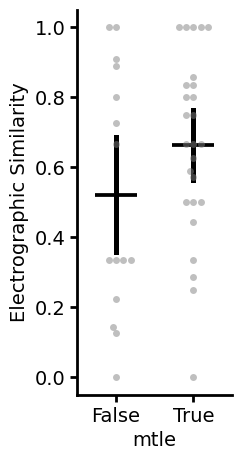

MannwhitneyuResult(statistic=251.5, pvalue=0.17135385567391426)


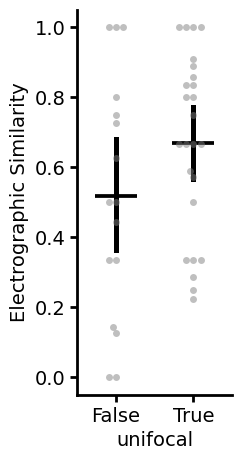

MannwhitneyuResult(statistic=275.0, pvalue=0.04569953534229786)


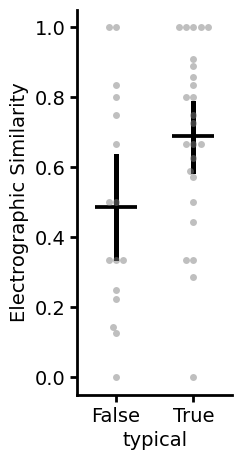

MannwhitneyuResult(statistic=187.0, pvalue=0.719267484396484)


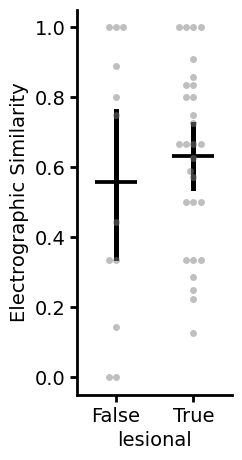

SignificanceResult(statistic=0.1910060486665895, pvalue=0.23159336051710622)


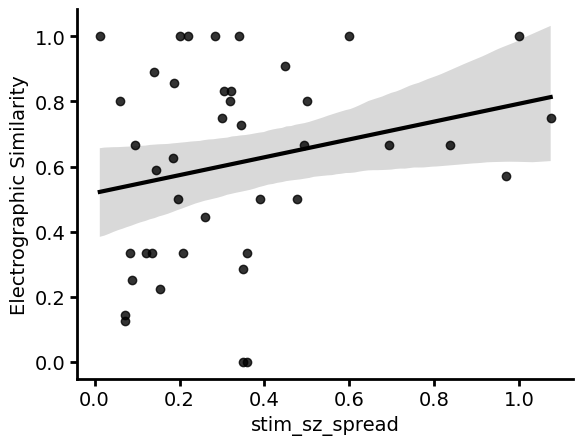

SignificanceResult(statistic=-0.2844547745359644, pvalue=0.07146478245305969)


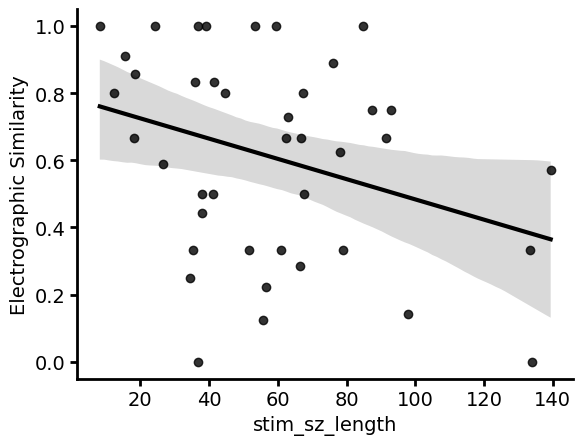

In [ ]:
for col in ['mtle','unifocal','typical','lesional','stim_sz_spread','stim_sz_length']:
    if lm_df_left[col].nunique() <= 3:
        print(sc.stats.mannwhitneyu(lm_df_left[lm_df_left[col]]['F1'],lm_df_left[~lm_df_left[col]]['F1']))
        _,ax = plt.subplots(figsize=(2,5))
        sns.swarmplot(lm_df_left,x=col,y='F1',color='gray',alpha=0.5)
        sns.pointplot(lm_df_left,x=col,y='F1',marker='_',linestyles='none',markersize=30,color='black')
        plt.ylabel('Electrographic Similarity')
        sns.despine()

    else:
        print(sc.stats.spearmanr(lm_df_left[col].values,lm_df_left['F1'].values))
        sns.regplot(lm_df_left,x=col,y='F1',color='black')
        plt.ylabel('Electrographic Similarity')
        sns.despine()

    plt.show()


### All patients

                            OLS Regression Results                            
Dep. Variable:                     F1   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     3.351
Date:                Sun, 20 Apr 2025   Prob (F-statistic):            0.00826
Time:                        01:28:25   Log-Likelihood:                 2.7117
No. Observations:                  41   AIC:                             10.58
Df Residuals:                      33   BIC:                             24.29
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.6438      0.132  

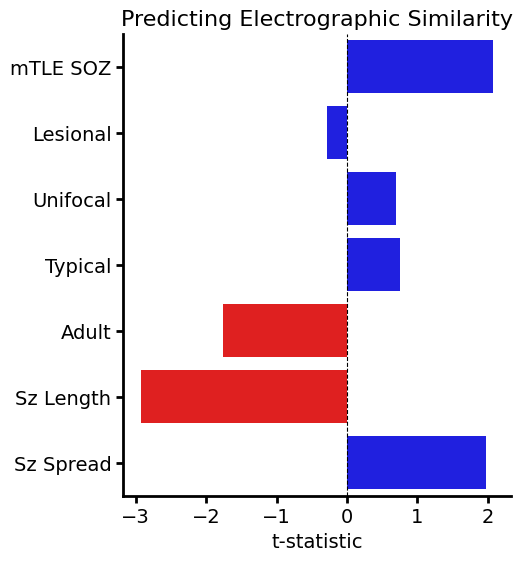

In [ ]:
dat = lm_df_left
# Fit regression model (using the natural log of one of the regressors)
results = smf.ols('F1 ~ typical + stim_sz_length + stim_sz_spread + unifocal + lesional + adult + mtle', data=dat).fit()
# results = smf.ols('F1 ~ typical', data=dat).fit()

# Inspect the results
print(results.summary())
tvals = results.tvalues
pvals = results.pvalues
vars = results.params.index

data = {
    'Variable': vars,
    't_statistic': tvals,
    'significant': pvals < 0.05  # True if p-value < 0.05
}
plot_order = ['mtle[T.True]','lesional[T.True]','unifocal[T.True]','typical[T.True]','adult[T.True]','stim_sz_length','stim_sz_spread']
# Create a DataFrame
df = pd.DataFrame(data)

# Set the color palette: orange for significant, purple for non-significant
palette = ['red' if sig else 'blue' for sig in df['significant']][1:]
# plot_order = ['Intercept','mtle[T.True]','unifocal[T.True]','typical[T.True]','stim_sz_length','stim_sz_spread']
# Plotting
plt.figure(figsize=(5, 6))
sns.barplot(
    data=df,
    y='Variable',
    x='t_statistic',
    palette=palette,
    # palette = ['red','blue','blue','blue','blue','blue','blue'],
    orient='h',
    order=plot_order,
)

# Add a vertical line at t = 0 for reference
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel('t-statistic')
plt.ylabel('')
plt.title('Predicting Electrographic Similarity')
plt.yticks(plt.yticks()[0],['mTLE SOZ','Lesional','Unifocal','Typical','Adult','Sz Length','Sz Spread'])
# plt.yticks(plt.yticks()[0],['mTLE SOZ','Unifocal','Typical','Adult','Sz Length','Sz Spread'])
sns.despine()
plt.savefig(ospj(figpath,'predicting_electrographic_similarity.pdf'))

### Just HUP

                            OLS Regression Results                            
Dep. Variable:                     F1   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     2.937
Date:                Sun, 20 Apr 2025   Prob (F-statistic):             0.0397
Time:                        01:24:23   Log-Likelihood:                 4.2595
No. Observations:                  23   AIC:                             5.481
Df Residuals:                      16   BIC:                             13.43
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.3990      0.165  

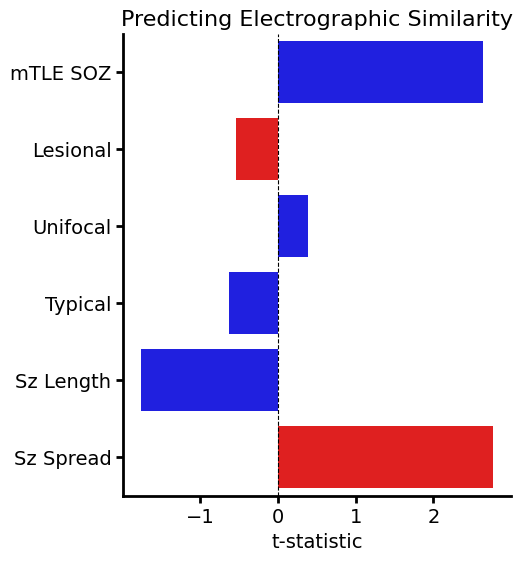

In [ ]:
dat = lm_df_left[lm_df_left.adult == True]
# Fit regression model (using the natural log of one of the regressors)
results = smf.ols('F1 ~ typical + stim_sz_length + stim_sz_spread + mtle + unifocal + lesional', data=dat).fit()
# results = smf.ols('F1 ~ typical', data=dat).fit()
# Inspect the results
print(results.summary())
tvals = results.tvalues
pvals = results.pvalues
vars = results.params.index

# Sample data: replace with your actual variables, t-stats, and significance info
data = {
    'Variable': vars,
    't_statistic': tvals,
    'significant': pvals < 0.05  # True if p-value < 0.05
}
plot_order = ['mtle[T.True]','lesional[T.True]','unifocal[T.True]','typical[T.True]','stim_sz_length','stim_sz_spread']
# Create a DataFrame
df = pd.DataFrame(data)

# Set the color palette: orange for significant, purple for non-significant
palette = ['red' if sig else 'blue' for sig in df['significant']][1:]
# plot_order = ['Intercept','mtle[T.True]','unifocal[T.True]','typical[T.True]','stim_sz_length','stim_sz_spread']
# Plotting
plt.figure(figsize=(5, 6))
sns.barplot(
    data=df,
    y='Variable',
    x='t_statistic',
    # palette=palette,
    palette = palette,
    orient='h',
    order=plot_order,
)

# Add a vertical line at t = 0 for reference
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel('t-statistic')
plt.ylabel('')
plt.title('Predicting Electrographic Similarity')
plt.yticks(plt.yticks()[0],['mTLE SOZ','Lesional','Unifocal','Typical','Sz Length','Sz Spread'])
sns.despine()
plt.savefig(ospj(figpath,'predicting_electrographic_similarity_HUP.pdf'))

### Just CHOP

                            OLS Regression Results                            
Dep. Variable:                     F1   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     1.884
Date:                Sun, 20 Apr 2025   Prob (F-statistic):              0.172
Time:                        01:24:23   Log-Likelihood:                 3.5755
No. Observations:                  18   AIC:                             6.849
Df Residuals:                      11   BIC:                             13.08
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.7204      0.324  

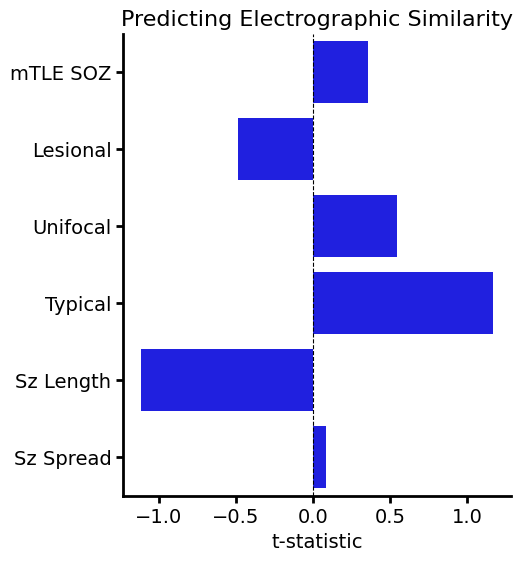

In [ ]:
dat = lm_df_left[lm_df_left.adult == False]
# Fit regression model (using the natural log of one of the regressors)
results = smf.ols('F1 ~ typical + stim_sz_length + stim_sz_spread + mtle + unifocal + lesional', data=dat).fit()
# results = smf.ols('F1 ~ typical', data=dat).fit()
# Inspect the results
print(results.summary())
tvals = results.tvalues
pvals = results.pvalues
vars = results.params.index

# Sample data: replace with your actual variables, t-stats, and significance info
data = {
    'Variable': vars,
    't_statistic': tvals,
    'significant': pvals < 0.05  # True if p-value < 0.05
}
plot_order = ['mtle[T.True]','lesional[T.True]','unifocal[T.True]','typical[T.True]','stim_sz_length','stim_sz_spread']
# Create a DataFrame
df = pd.DataFrame(data)

# Set the color palette: orange for significant, purple for non-significant
palette = ['red' if sig else 'blue' for sig in df['significant']][1:]
# plot_order = ['Intercept','mtle[T.True]','unifocal[T.True]','typical[T.True]','stim_sz_length','stim_sz_spread']
# Plotting
plt.figure(figsize=(5, 6))
sns.barplot(
    data=df,
    y='Variable',
    x='t_statistic',
    palette=palette,
    # palette = ['blue','blue','blue','blue','blue'],
    orient='h',
    order=plot_order,
)

# Add a vertical line at t = 0 for reference
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel('t-statistic')
plt.ylabel('')
plt.title('Predicting Electrographic Similarity')
plt.yticks(plt.yticks()[0],['mTLE SOZ','Lesional','Unifocal','Typical','Sz Length','Sz Spread'])
sns.despine()
plt.savefig(ospj(figpath,'predicting_electrographic_similarity_CHOP.pdf'))

### MISC

In [ ]:
df_grouped = model_df_wtypical.groupby('approximate_onset')
test_df = lm_df_grouped[[l for l in lm_df.columns if l != 'F1']].max()
test_df['F1'] = lm_df_grouped['F1'].apply(lambda x: np.max(x))
test_df.reset_index(drop=True,inplace=True)

In [ ]:
lm_df

,kappa,F1,patient,iEEG_ID,approximate_onset,stim_sz_length,stim_sz_spread,to_annotate,typical,mtle,outcome,unifocal,lesional,adult
0,0.317073,0.500000,HUP229,HUP229_phaseII,1109.40,67.51,0.390244,1.0,True,True,0.0,True,True,True
1,0.278689,0.333333,CHOP035,CHOPCCEP_035,2872.35,26.71,0.145349,1.0,True,True,NaN,True,True,False
2,0.338346,0.555556,CHOP035,CHOPCCEP_035,2872.35,26.71,0.145349,1.0,True,True,NaN,True,True,False
3,0.393701,0.588235,CHOP035,CHOPCCEP_035,2872.35,26.71,0.145349,1.0,True,True,NaN,True,True,False
4,0.129496,0.421053,CHOP035,CHOPCCEP_035,2872.35,26.71,0.145349,1.0,True,True,NaN,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,0.666667,0.800000,CHOP049,CHOP049,241395.80,15.43,0.448529,1.0,True,False,NaN,True,True,False
510,0.698630,0.750000,CHOP044,CHOP044,290592.89,76.14,0.140496,1.0,True,False,NaN,True,False,False
511,0.860759,0.888889,CHOP044,CHOP044,290592.89,76.14,0.140496,1.0,True,False,NaN,True,False,False
512,0.179104,0.285714,CHOP044,CHOP044,290592.89,76.14,0.140496,1.0,True,False,NaN,True,False,False


In [ ]:
sc.stats.ttest_ind(model_df_wtypical.loc[model_df_wtypical.typical == 0,'kappa'],model_df_wtypical.loc[model_df_wtypical.typical == 1,'kappa'])

TtestResult(statistic=nan, pvalue=nan, df=nan)